# Tutorial

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib


In [4]:

from import_excel import import_excel
from calc_translations import load_trans
from calc_translations import translate
from wavelet_decomposition import compute_betas
from wavelet_decomposition import stack_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct
from wavelet_decomposition import sine_function
from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft

# All control parameters goes here

In [5]:
#
# Path
path_input_data = "C:\\Users\\AC252489\\Documents\\These\\RTE_time_series\\"
input_file = 'input_time_series.xlsx'
#
beta_path = "betas\\square_shape\\"

#
path_trans = 'translation//'


In [6]:
#
# Options of the wavelet decomposition
vy = 6  # vectors per yearsave
vw = 3  # vectors per week
vd = 6  # vectors per day

vecNb_yr = vy
vecNb_week = vw
vecNb_day = vd

time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

# 
# Controle parameters"
time_series = ['Consommation', 'Eolien', 'Solaire']
# for the signal interpolation
dpd = 48 # data per year
ndpd = 64 # new data per year (for the interpolation)
dpy = 365 # data per year :  cut the leap years to 365 years (annee bissexitle)
signal_length = ndpd * dpy

#
load_factor = 54e+3 # 54 GW
#Mean value of electricity load

# Importing excel time series

There is 7 years imported
[u'2012', u'2013', u'2014', u'2015', u'2016', u'2017', u'2018']


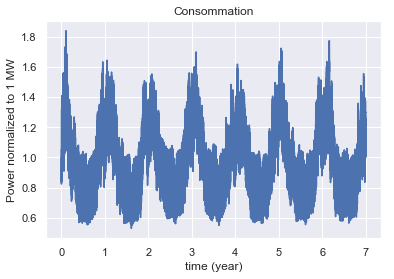

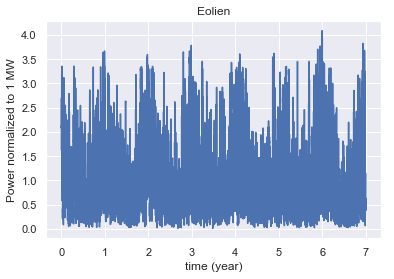

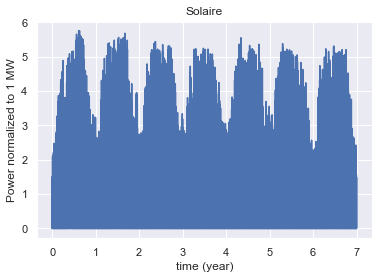

In [10]:

# stacked_input_data, years = import_excel(path_input_data,input_file, 
#                                     dpd ,ndpd, dpy, time_series, 
#                                     interp=True)


# # Delme after getting a clean code
# pkl.dump([stacked_input_data, years], open('temp_save' + '.p', "wb") )

[stacked_input_data, years]= pkl.load(open('temp_save' + '.p', "rb"))

# Starting the wavelet decomposition

In [11]:
'''
First, we to compute the appopriate translations for each year
'''
trans_file = 'new_trans_square_12_18'

trans_square = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'square', do_calc = False)

Importing translations


ValueError: unsupported pickle protocol: 3

In [ ]:
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine_function' or 'square' sgape
'''
path_matrix = "saved_matrix\\square_shape\\"
# stacked_betas_square, saved_sheets_square = compute_betas(time_series, stacked_input_data,
#                  vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
#                  trans_square,
#                  path_matrix,
#                  beta_path, wl_shape ='square', imp_matrix = False)

# pkl.dump([stacked_betas_square, saved_sheets_square], open('betas_saved_square' + '.p', "wb"))

[stacked_betas_square, saved_sheets_square] = pkl.load(open('betas_saved_square' + '.p', "rb"))

In [ ]:
print(saved_sheets_square.keys())
print(saved_sheets_square['Consommation'].keys())
print(saved_sheets_square['Consommation']["2012"][14]) # 14th time scale

## Plots
### We represent each year decomposition one the heat maps bellow
### The wavelet transform is also compared with the fourier transform

In [ ]:
year = '2018'
df_conso = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years,saved_sheets_square, do_trans = trans_square)
df_eol   = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Eolien', year, years, saved_sheets_square,   do_trans = trans_square)
df_pv    = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Solaire', year, years, saved_sheets_square,  do_trans = trans_square)

In [ ]:
plot_betas_heatmap(df_conso, 'Consommation', year , ndpd,
                      cmin= None,
                      cmax= 0.2,
                    ccenter = None)
plot_betas_heatmap(df_eol, 'Eolien', year ,ndpd,
                      cmin= None,
                      cmax = 3,
                      ccenter= None)
plot_betas_heatmap(df_pv, 'Solaire', year ,ndpd,
                      cmin= None,
                      cmax=2,
                      ccenter= None)


## Comparison with a FFT

In [ ]:
# importlib.reload(plots.fft)
index = years.index(year)
for signal in time_series:
    input_data = stacked_input_data[signal][signal_length*index:signal_length*(index+1)]
    fft(ndpd, dpy, signal, year, input_data)

# Computing Energy, Power, and Nb of Cycles
### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

#### First example with only one year

In [ ]:
#
# Define here the energy mix, the years you want to include to the wavelet decomposition
chosen_years = ['2012']
short_stacked_betas = stack_betas(saved_sheets_square, time_series, chosen_years)
#
scenario_name = 'PV'
conso = short_stacked_betas['Consommation']
prod =  short_stacked_betas['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [95]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

In [ ]:
#### With 7 years now

In [ ]:
scenario_name = 'PV'
conso = stacked_betas_square['Consommation']
prod =  stacked_betas_square['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

In [ ]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
# reconstruct(time_scales, [24],
#                 matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 filtré par des ondelettes de 24h",
#                 xmin=150, xmax=154,
#                 dpy=365, dpd=64,
#                 add_offset=True)

# reconstruct(time_scales, [12,24],
#                 matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
#                 xmin=150, xmax=154,
#                 dpy=365, dpd=64,
#                 add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

# Investigation of the correlation at the week scale between Wind and consumption signal in 2018

In [ ]:
year = '2018'

path_matrix = "saved_matrix\\square_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#
reconstruct(time_scales, [168],
                matrix,saved_sheets_square['Eolien'][year], "2018 wind power generation filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [168],
                matrix,saved_sheets_square['Consommation'][year], "2018 Consumption filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

In [ ]:
# For the scame 11 days 

reconstruct(time_scales, [273.75],
                matrix,saved_sheets_square['Eolien'][year], "2018 wind power generation filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)


reconstruct(time_scales, [273.75],
                matrix,saved_sheets_square['Consommation'][year], "2018 Consumption filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

### Analysis
--

There is, in 2018, correlations between wind and consumption cycles at the week and 11 days scale, in 2018.

In other words, we saw that in winter, (december - january) with cold weather and strong electricity consumptions over a week or more, there is luckily a lot of wind.

# Sine wavelets
## We analyse here the results between sine_function wavelets and square wavelets

In [12]:
'''
First, we to compute the appopriate translations for each year
'''
trans_file = 'new_trans_sine_12_18'

# input_data = stacked_input_data['Consommation']
# from calc_translations import calc_trans
# trans_sine = calc_trans(ndpd, dpy, input_data, 'sine')

# pkl.dump(trans_sine, open('temp_new_trans_sine2' + '.p', "wb"))

trans_sine = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'sine', do_calc=False)

Computing translations began...
0
1204.4327130746833
2552
1204.407361827354
2553
1204.2789902750403
2554
1204.1505345122366
2555
1204.021994576116
2556
1203.8933705038758
2557
1203.764662332738
2558
1203.6358700999483
2559
1203.5069938427773
2560
1203.3780335985196
2561
1203.248989404494
2562
1203.1198612980438
2563
1202.9906493165372
2564
1202.8613534973656
2565
1202.7319738779447
2566
1202.6025104957153
2567
1202.472963388142
2568
1202.3433325927135
2569
1202.2136181469427
2570
1202.0838200883672
2571
1201.9539384545483
2572
1201.8239732830714
2573
1201.6939246115467
2574
1201.5637924776076
2575
1201.4335769189129
2576
1201.3032779731443
2577
1201.1728956780084
2578
1201.042430071236
2579
1200.911881190581
2580
1200.781249073823
2581
1200.650533758764
2582
1200.5197352832313
2583
1200.388853685076
2584
1200.2578890021725
2585
1200.1268412724203
2586
1199.9957105337426
2587
1199.864496824086
2588
1199.7332001814223
2589
1199.601820643746
2590
1199.4703582490763
2591
1199.3388130354563

2897
1155.388015996177
2898
1155.2329564155386
2899
1155.0778268175322
2900
1154.92262724705
2901
1154.767357749004
2902
1154.612018368327
2903
1154.456609149971
2904
1154.3011301389092
2905
1154.1455813801354
2906
1153.9899629186616
2907
1153.8342747995225
2908
1153.6785170677706
2909
1153.5226897684802
2910
1153.3667929467454
2911
1153.2108266476798
2912
1153.0547909164175
2913
1152.898685798113
2914
1152.7425113379404
2915
1152.5862675810936
2916
1152.429954572788
2917
1152.2735723582573
2918
1152.117120982756
2919
1151.9606004915586
2920
1151.80401092996
2921
1151.6473523432742
2922
1151.4906247768358
2923
1151.3338282759992
2924
1151.1769628861387
2925
1151.0200286526483
2926
1150.863025620943
2927
1150.7059538364563
2928
1150.5488133446422
2929
1150.391604190975
2930
1150.234326420948
2931
1150.076980080075
2932
1149.9195652138897
2933
1149.7620818679447
2934
1149.6045300878143
2935
1149.44690991909
2936
1149.2892214073859
2937
1149.1314645983334
2938
1148.9736395375853
2939
1148

3249
1096.817346034382
3250
1096.6405511053106
3251
1096.4637031145576
3252
1096.2868021132995
3253
1096.1098481527288
3254
1095.9328412840528
3255
1095.755781558495
3256
1095.578669027293
3257
1095.4015037417005
3258
1095.2242857529864
3259
1095.0470151124346
3260
1094.869691871344
3261
1094.6923160810293
3262
1094.5148877928204
3263
1094.3374070580617
3264
1094.1598739281137
3265
1093.9822884543514
3266
1093.8046506881649
3267
1093.6269606809599
3268
1093.449218484157
3269
1093.2714241491917
3270
1093.093577727515
3271
1092.9156792705926
3272
1092.7377288299058
3273
1092.5597264569499
3274
1092.3816722032363
3275
1092.2035661202908
3276
1092.0254082596548
3277
1091.8471986728837
3278
1091.668937411549
3279
1091.4906245272364
3280
1091.3122600715465
3281
1091.133844096095
3282
1090.955376652513
3283
1090.7768577924462
3284
1090.598287567554
3285
1090.419666029513
3286
1090.240993230013
3287
1090.0622692207583
3288
1089.8834940534693
3289
1089.7046677798805
3290
1089.5257904517414
3291

3600
1031.8775980842724
3601
1031.6854222759812
3602
1031.4932122029625
3603
1031.300967920839
3604
1031.1086894852428
3605
1030.9163769518163
3606
1030.7240303762114
3607
1030.5316498140905
3608
1030.339235321125
3609
1030.1467869529968
3610
1029.954304765397
3611
1029.7617888140269
3612
1029.5692391545977
3613
1029.37665584283
3614
1029.1840389344543
3615
1028.9913884852106
3616
1028.798704550849
3617
1028.605987187129
3618
1028.4132364498196
3619
1028.2204523947003
3620
1028.0276350775594
3621
1027.8347845541948
3622
1027.6419008804148
3623
1027.4489841120364
3624
1027.2560343048867
3625
1027.0630515148023
3626
1026.870035797629
3627
1026.6769872092227
3628
1026.4839058054486
3629
1026.2907916421807
3630
1026.0976447753037
3631
1025.9044652607108
3632
1025.7112531543053
3633
1025.5180085119994
3634
1025.324731389715
3635
1025.1314218433836
3636
1024.9380799289452
3637
1024.7447057023505
3638
1024.5512992195586
3639
1024.3578605365378
3640
1024.1643897092665
3641
1023.970886793732
36

3958
961.316721618894
3959
961.1158975921915
3960
960.9150597224304
3961
960.7142080677302
3962
960.513342686214
3963
960.3124636360089
3964
960.1115709752462
3965
959.9106647620608
3966
959.7097450545918
3967
959.5088119109821
3968
959.3078653893782
3969
959.106905547931
3970
958.905932444795
3971
958.7049461381284
3972
958.5039466860935
3973
958.3029341468562
3974
958.1019085785861
3975
957.900870039457
3976
957.699818587646
3977
957.4987542813341
3978
957.2976771787062
3979
957.0965873379504
3980
956.8954848172591
3981
956.6943696748281
3982
956.4932419688566
3983
956.2921017575479
3984
956.0909490991087
3985
955.8897840517493
3986
955.6886066736834
3987
955.4874170231285
3988
955.2862151583058
3989
955.0850011374395
3990
954.8837750187579
3991
954.6825368604926
3992
954.4812867208785
3993
954.280024658154
3994
954.0787507305615
3995
953.8774649963459
3996
953.6761675137564
3997
953.4748583410449
3998
953.2735375364671
3999
953.0722051582818
4000
952.8708612647515
4001
952.669505914

4319
888.3735952533655
4320
888.1715697391726
4321
887.9695514908198
4322
887.7675405667676
4323
887.5655370254749
4324
887.3635409253977
4325
887.1615523249912
4326
886.9595712827072
4327
886.7575978569953
4328
886.5556321063041
4329
886.3536740890786
4330
886.1517238637623
4331
885.9497814887966
4332
885.7478470226199
4333
885.5459205236689
4334
885.344002050378
4335
885.1420916611789
4336
884.9401894145012
4337
884.7382953687722
4338
884.5364095824168
4339
884.3345321138572
4340
884.1326630215136
4341
883.9308023638037
4342
883.7289501991427
4343
883.527106585943
4344
883.3252715826152
4345
883.1234452475669
4346
882.9216276392035
4347
882.7198188159275
4348
882.5180188361392
4349
882.3162277582362
4350
882.1144456406136
4351
881.9126725416636
4352
881.7109085197765
4353
881.5091536333391
4354
881.3074079407361
4355
881.1056715003496
4356
880.9039443705585
4357
880.7022266097397
4358
880.5005182762668
4359
880.2988194285108
4360
880.0971301248403
4361
879.8954504236209
4362
879.6937

4682
815.9755574736943
4683
815.7799817597224
4684
815.584434260535
4685
815.38891503272
4686
815.1934241328578
4687
814.99796161752
4688
814.8025275432705
4689
814.6071219666644
4690
814.4117449442493
4691
814.216396532564
4692
814.0210767881389
4693
813.8257857674967
4694
813.6305235271509
4695
813.435290123608
4696
813.2400856133647
4697
813.0449100529102
4698
812.8497634987251
4699
812.6546460072817
4700
812.4595576350439
4701
812.2644984384668
4702
812.0694684739976
4703
811.8744677980749
4704
811.6794964671283
4705
811.4845545375797
4706
811.2896420658419
4707
811.0947591083195
4708
810.8999057214083
4709
810.7050819614959
4710
810.510287884961
4711
810.3155235481738
4712
810.1207890074961
4713
809.9260843192806
4714
809.731409539872
4715
809.5367647256057
4716
809.3421499328088
4717
809.1475652177999
4718
808.9530106368883
4719
808.758486246375
4720
808.5639921025522
4721
808.3695282617036
4722
808.1750947801036
4723
807.9806917140181
4724
807.7863191197042
4725
807.591977053410

5041
748.0033683140837
5042
747.8214845474149
5043
747.6396486616106
5044
747.4578607092913
5045
747.2761207430634
5046
747.0944288155194
5047
746.912784979238
5048
746.7311892867842
5049
746.5496417907085
5050
746.368142543548
5051
746.1866915978255
5052
746.0052890060499
5053
745.8239348207164
5054
745.6426290943056
5055
745.4613718792848
5056
745.2801632281064
5057
745.0990031932097
5058
744.9178918270193
5059
744.7368291819457
5060
744.5558153103857
5061
744.3748502647215
5062
744.193934097322
5063
744.0130668605407
5064
743.8322486067179
5065
743.6514793881795
5066
743.4707592572372
5067
743.2900882661884
5068
743.1094664673162
5069
742.9288939128899
5070
742.7483706551639
5071
742.5678967463789
5072
742.3874722387611
5073
742.2070971845226
5074
742.0267716358604
5075
741.8464956449584
5076
741.6662692639852
5077
741.4860925450955
5078
741.3059655404294
5079
741.1258883021128
5080
740.945860882257
5081
740.7658833329592
5082
740.5859557063018
5083
740.406078054353
5084
740.2262504

5405
685.3697065458963
5406
685.2086065175686
5407
685.0475724892506
5408
684.8866045075432
5409
684.7257026190279
5410
684.5648668702668
5411
684.4040973078035
5412
684.2433939781617
5413
684.0827569278467
5414
683.9221862033439
5415
683.7616818511203
5416
683.6012439176227
5417
683.4408724492796
5418
683.2805674924998
5419
683.1203290936728
5420
682.9601572991692
5421
682.8000521553399
5422
682.6400137085168
5423
682.4800420050125
5424
682.32013709112
5425
682.1602990131134
5426
682.0005278172471
5427
681.8408235497564
5428
681.6811862568568
5429
681.521615984745
5430
681.362112779598
5431
681.2026766875736
5432
681.0433077548095
5433
680.8840060274249
5434
680.724771551519
5435
680.5656043731716
5436
680.4065045384432
5437
680.2474720933747
5438
680.0885070839872
5439
679.9296095562829
5440
679.7707795562442
5441
679.6120171298336
5442
679.4533223229946
5443
679.2946951816507
5444
679.1361357517062
5445
678.9776440790456
5446
678.8192202095337
5447
678.6608641890158
5448
678.5025760

5777
630.3757340212371
5778
630.2422288048182
5779
630.108805494782
5780
629.9754641297392
5781
629.8422047482763
5782
629.7090273889568
5783
629.5759320903195
5784
629.4429188908805
5785
629.3099878291316
5786
629.1771389435407
5787
629.044372272552
5788
628.9116878545864
5789
628.7790857280402
5790
628.6465659312864
5791
628.5141285026743
5792
628.381773480529
5793
628.2495009031518
5794
628.1173108088203
5795
627.985203235788
5796
627.8531782222849
5797
627.7212358065168
5798
627.5893760266656
5799
627.4575989208895
5800
627.3259045273226
5801
627.1942928840751
5802
627.0627640292332
5803
626.9313180008594
5804
626.7999548369917
5805
626.6686745756449
5806
626.5374772548088
5807
626.4063629124503
5808
626.2753315865115
5809
626.1443833149108
5810
626.0135181355424
5811
625.8827360862765
5812
625.7520372049596
5813
625.6214215294135
5814
625.4908890974364
5815
625.3604399468022
5816
625.2300741152608
5817
625.099791640538
5818
624.9695925603352
5819
624.8394769123302
5820
624.7094447

6135
588.0912480717179
6136
587.9893456663069
6137
587.8875373945738
6138
587.7858232859799
6139
587.6842033699597
6140
587.5826776759205
6141
587.481246233242
6142
587.379909071277
6143
587.2786662193507
6144
587.1775177067611
6145
587.076463562779
6146
586.9755038166477
6147
586.8746384975836
6148
586.7738676347751
6149
586.6731912573838
6150
586.5726093945439
6151
586.472122075362
6152
586.3717293289176
6153
586.2714311842626
6154
586.1712276704218
6155
586.0711188163923
6156
585.9711046511443
6157
585.8711852036197
6158
585.7713605027341
6159
585.6716305773748
6160
585.5719954564022
6161
585.472455168649
6162
585.3730097429207
6163
585.2736592079948
6164
585.174403592622
6165
585.0752429255253
6166
584.9761772354
6167
584.8772065509143
6168
584.7783309007084
6169
584.6795503133956
6170
584.5808648175612
6171
584.4822744417634
6172
584.3837792145323
6173
584.2853791643712
6174
584.1870743197551
6175
584.0888647091322
6176
583.9907503609223
6177
583.8927313035185
6178
583.79480756528

6494
557.7637694824105
6495
557.6973405164465
6496
557.6310144501726
6497
557.5647913027819
6498
557.4986710934387
6499
557.4326538412769
6500
557.3667395654007
6501
557.3009282848849
6502
557.235220018774
6503
557.169614786083
6504
557.104112605797
6505
557.0387134968712
6506
556.973417478231
6507
556.9082245687721
6508
556.8431347873602
6509
556.7781481528312
6510
556.7132646839914
6511
556.6484843996166
6512
556.5838073184535
6513
556.5192334592185
6514
556.4547628405982
6515
556.3903954812492
6516
556.3261313997987
6517
556.2619706148434
6518
556.1979131449505
6519
556.1339590086571
6520
556.0701082244706
6521
556.0063608108683
6522
555.9427167862978
6523
555.8791761691763
6524
555.8157389778917
6525
555.7524052308016
6526
555.6891749462338
6527
555.6260481424861
6528
555.5630248378264
6529
555.5001050504926
6530
555.4372887986926
6531
555.3745761006044
6532
555.3119669743761
6533
555.2494614381256
6534
555.1870595099413
6535
555.124761207881
6536
555.0625665499729
6537
555.0004755

6860
540.4573348728602
6861
540.4296042447647
6862
540.4019815133598
6863
540.3744666866394
6864
540.3470597725659
6865
540.3197607790702
6866
540.2925697140522
6867
540.2654865853808
6868
540.2385114008931
6869
540.2116441683955
6870
540.1848848956629
6871
540.1582335904388
6872
540.131690260436
6873
540.1052549133356
6874
540.0789275567872
6875
540.0527081984098
6876
540.0265968457911
6877
540.0005935064869
6878
539.9746981880221
6879
539.9489108978909
6880
539.9232316435551
6881
539.8976604324463
6882
539.8721972719642
6883
539.8468421694774
6884
539.8215951323233
6885
539.7964561678082
6886
539.7714252832064
6887
539.7465024857619
6888
539.7216877826868
6889
539.6969811811618
6890
539.6723826883372
6891
539.6478923113308
6892
539.62351005723
6893
539.5992359330905
6894
539.575069945937
6895
539.5510121027627
6896
539.5270624105294
6897
539.5032208761679
6898
539.4794875065775
6899
539.4558623086264
6900
539.432345289151
6901
539.4089364549569
6902
539.3856358128185
6903
539.3624433

22582
1192.4458542712828
22583
1192.3947631646968
22584
1192.3730253391407
0
1235.0633526130064
16
1231.8299608662
17
1222.7770649186627
18
1214.023667350718
19
1205.8631515456857
20
1198.5660353586054
21
1192.3699024281702
22
1187.4845192690382
23
1184.0725359009386
24
1182.2429875287016
25
1182.0473537324751
[25, 22584, 7116]
0
1103.1341504333243
3309
1103.0533332081886
3310
1102.8825694127302
3311
1102.7117313007584
3312
1102.5408189217114
3313
1102.3698323250487
3314
1102.1987715602504
3315
1102.0276366768194
3316
1101.8564277242788
3317
1101.6851447521735
3318
1101.5137878100709
3319
1101.342356947558
3320
1101.1708522142449
3321
1100.9992736597615
3322
1100.8276213337604
3323
1100.6558952859143
3324
1100.4840955659188
3325
1100.3122222234892
3326
1100.1402753083632
3327
1099.9682548702995
3328
1099.7961609590775
3329
1099.6239936244992
3330
1099.4517529163863
3331
1099.2794388845828
3332
1099.1070515789534
3333
1098.9345910493844
3334
1098.762057345783
3335
1098.5894505180772
333

3645
1041.8146371850457
3646
1041.621812388752
3647
1041.4289310038087
3648
1041.2359930860327
3649
1041.042998691257
3650
1040.8499478753313
3651
1040.656840694121
3652
1040.4636772035083
3653
1040.2704574593913
3654
1040.0771815176852
3655
1039.8838494343204
3656
1039.6904612652445
3657
1039.4970170664205
3658
1039.303516893828
3659
1039.1099608034633
3660
1038.9163488513377
3661
1038.7226810934794
3662
1038.5289575859333
3663
1038.3351783847595
3664
1038.1413435460342
3665
1037.9474531258506
3666
1037.753507180317
3667
1037.5595057655582
3668
1037.3654489377157
3669
1037.1713367529453
3670
1036.9771692674208
3671
1036.7829465373306
3672
1036.5886686188799
3673
1036.394335568289
3674
1036.1999474417958
3675
1036.005504295652
3676
1035.8110061861266
3677
1035.6164531695044
3678
1035.4218453020858
3679
1035.2271826401868
3680
1035.03246524014
3681
1034.837693158293
3682
1034.6428664510101
3683
1034.447985174671
3684
1034.2530493856707
3685
1034.0580591404212
3686
1033.8630144953486
368

4000
970.2286666597329
4001
970.0193703776945
4002
969.8100382275852
4003
969.6006702699822
4004
969.3912665654731
4005
969.1818271746558
4006
968.9723521581391
4007
968.762841576541
4008
968.5532954904909
4009
968.3437139606281
4010
968.1340970476017
4011
967.9244448120717
4012
967.714757314708
4013
967.5050346161906
4014
967.2952767772099
4015
967.0854838584664
4016
966.8756559206707
4017
966.6657930245437
4018
966.4558952308164
4019
966.2459626002294
4020
966.035995193534
4021
965.8259930714914
4022
965.6159562948728
4023
965.4058849244593
4024
965.1957790210422
4025
964.9856386454226
4026
964.7754638584119
4027
964.5652547208313
4028
964.3550112935116
4029
964.1447336372938
4030
963.9344218130291
4031
963.7240758815782
4032
963.5136959038118
4033
963.3032819406104
4034
963.0928340528643
4035
962.8823523014739
4036
962.671836747349
4037
962.4612874514094
4038
962.2507044745846
4039
962.0400878778139
4040
961.8294377220464
4041
961.6187540682407
4042
961.4080369773653
4043
961.197286

4370
890.8547389450599
4371
890.6363799358053
4372
890.4180080306215
4373
890.1996232927024
4374
889.9812257852449
4375
889.7628155714492
4376
889.54439271452
4377
889.3259572776653
4378
889.1075093240967
4379
888.8890489170293
4380
888.6705761196824
4381
888.4520909952781
4382
888.2335936070426
4383
888.0150840182052
4384
887.7965622919994
4385
887.5780284916617
4386
887.3594826804322
4387
887.1409249215544
4388
886.9223552782753
4389
886.7037738138455
4390
886.4851805915191
4391
886.266575674553
4392
886.0479591262083
4393
885.8293310097488
4394
885.6106913884421
4395
885.3920403255586
4396
885.1733778843727
4397
884.9547041281617
4398
884.7360191202059
4399
884.5173229237896
4400
884.2986156021998
4401
884.0798972187265
4402
883.8611678366636
4403
883.6424275193078
4404
883.4236763299588
4405
883.2049143319197
4406
882.9861415884966
4407
882.7673581629989
4408
882.5485641187388
4409
882.3297595190319
4410
882.1109444271965
4411
881.8921189065541
4412
881.6732830204294
4413
881.45443

4733
811.2444454984093
4734
811.025573563071
4735
810.8067117698725
4736
810.5878601821486
4737
810.3690188632313
4738
810.1501878764498
4739
809.9313672851301
4740
809.7125571525955
4741
809.4937575421661
4742
809.2749685171588
4743
809.0561901408875
4744
808.8374224766633
4745
808.6186655877938
4746
808.3999195375839
4747
808.1811843893347
4748
807.9624602063452
4749
807.7437470519103
4750
807.5250449893219
4751
807.3063540818689
4752
807.0876743928371
4753
806.8690059855085
4754
806.6503489231623
4755
806.4317032690744
4756
806.2130690865171
4757
805.9944464387595
4758
805.7758353890677
4759
805.5572360007042
4760
805.3386483369277
4761
805.1200724609942
4762
804.9015084361561
4763
804.682956325662
4764
804.4644161927573
4765
804.245888100684
4766
804.027372112681
4767
803.8088682919827
4768
803.5903767018206
4769
803.3718974054228
4770
803.1534304660136
4771
802.9349759468137
4772
802.7165339110404
4773
802.4981044219071
4774
802.2796875426238
4775
802.061283336397
4776
801.8428918

5093
733.591403159927
5094
733.3802397747683
5095
733.1691090010419
5096
732.9580108998455
5097
732.7469455322675
5098
732.5359129593869
5099
732.324913242273
5100
732.1139464419857
5101
731.9030126195753
5102
731.6921118360825
5103
731.4812441525387
5104
731.2704096299657
5105
731.0596083293754
5106
730.8488403117701
5107
730.6381056381429
5108
730.4274043694768
5109
730.2167365667453
5110
730.0061022909124
5111
729.7955016029323
5112
729.5849345637489
5113
729.3744012342975
5114
729.1639016755023
5115
728.9534359482792
5116
728.7430041135331
5117
728.5326062321594
5118
728.3222423650443
5119
728.1119125730633
5120
727.9016169170826
5121
727.6913554579581
5122
727.4811282565363
5123
727.2709353736534
5124
727.0607768701359
5125
726.8506528068
5126
726.6405632444523
5127
726.4305082438893
5128
726.2204878658977
5129
726.0105021712536
5130
725.8005512207235
5131
725.5906350750641
5132
725.3807537950214
5133
725.1709074413317
5134
724.9610960747211
5135
724.7513197559057
5136
724.5415785

5453
660.1437151881644
5454
659.9481551312211
5455
659.7526489357573
5456
659.5571966583492
5457
659.3617983555575
5458
659.1664540839275
5459
658.9711638999884
5460
658.7759278602541
5461
658.5807460212225
5462
658.3856184393765
5463
658.1905451711824
5464
657.9955262730913
5465
657.8005618015388
5466
657.6056518129441
5467
657.4107963637111
5468
657.2159955102277
5469
657.0212493088662
5470
656.826557815983
5471
656.6319210879185
5472
656.4373391809975
5473
656.2428121515288
5474
656.0483400558053
5475
655.8539229501042
5476
655.6595608906864
5477
655.4652539337973
5478
655.2710021356661
5479
655.0768055525062
5480
654.8826642405147
5481
654.6885782558732
5482
654.4945476547467
5483
654.3005724932848
5484
654.1066528276205
5485
653.9127887138711
5486
653.718980208138
5487
653.5252273665055
5488
653.3315302450432
5489
653.1378888998036
5490
652.9443033868233
5491
652.7507737621229
5492
652.5573000817067
5493
652.3638824015627
5494
652.170520777663
5495
651.9772152659632
5496
651.78396

5822
592.0962025542311
5823
591.924216917263
5824
591.7523048267924
5825
591.5804663325673
5826
591.4087014843155
5827
591.2370103317428
5828
591.0653929245336
5829
590.8938493123512
5830
590.7223795448378
5831
590.5509836716138
5832
590.3796617422784
5833
590.2084138064092
5834
590.0372399135626
5835
589.8661401132739
5836
589.6951144550561
5837
589.5241629884015
5838
589.3532857627807
5839
589.1824828276426
5840
589.0117542324149
5841
588.8411000265037
5842
588.6705202592934
5843
588.5000149801471
5844
588.3295842384061
5845
588.1592280833906
5846
587.9889465643987
5847
587.8187397307071
5848
587.6486076315708
5849
587.4785503162234
5850
587.3085678338765
5851
587.1386602337207
5852
586.9688275649239
5853
586.7990698766332
5854
586.6293872179738
5855
586.459779638049
5856
586.2902471859404
5857
586.120789910708
5858
585.95140786139
5859
585.7821010870026
5860
585.6128696365407
5861
585.4437135589769
5862
585.2746329032624
5863
585.1056277183262
5864
584.9366980530758
5865
584.7678439

6188
534.4487731243676
6189
534.3068456125926
6190
534.1650083208419
6191
534.0232612901614
6192
533.8816045615697
6193
533.7400381760602
6194
533.5985621746
6195
533.45717659813
6196
533.3158814875648
6197
533.1746768837927
6198
533.0335628276762
6199
532.8925393600514
6200
532.7516065217281
6201
532.6107643534901
6202
532.4700128960949
6203
532.3293521902734
6204
532.1887822767308
6205
532.0483031961453
6206
531.9079149891697
6207
531.7676176964299
6208
531.6274113585257
6209
531.4872960160303
6210
531.3472717094912
6211
531.2073384794287
6212
531.0674963663375
6213
530.9277454106856
6214
530.7880856529146
6215
530.6485171334396
6216
530.5090398926498
6217
530.3696539709072
6218
530.2303594085481
6219
530.0911562458821
6220
529.9520445231921
6221
529.8130242807349
6222
529.6740955587409
6223
529.5352583974134
6224
529.3965128369298
6225
529.2578589174409
6226
529.1192966790707
6227
528.980826161917
6228
528.8424474060508
6229
528.7041604515167
6230
528.5659653383327
6231
528.42786210

6551
489.1621592611927
6552
489.0554638618792
6553
488.94887177760165
6554
488.8423830392061
6555
488.73599767750864
6556
488.62971572329536
6557
488.52353720732276
6558
488.41746216031686
6559
488.31149061297424
6560
488.2056225959614
6561
488.0998581399146
6562
487.9941972754405
6563
487.88864003311556
6564
487.78318644348644
6565
487.67783653706954
6566
487.5725903443515
6567
487.4674478957889
6568
487.36240922180804
6569
487.2574743528057
6570
487.152643319148
6571
487.0479161511715
6572
486.94329287918254
6573
486.8387735334573
6574
486.7343581442421
6575
486.63004674175295
6576
486.525839356176
6577
486.421736017667
6578
486.3177367563518
6579
486.21384160232617
6580
486.11005058565553
6581
486.0063637363755
6582
485.9027810844912
6583
485.79930265997785
6584
485.69592849278035
6585
485.5926586128135
6586
485.4894930499621
6587
485.3864318340803
6588
485.2834749949925
6589
485.18062256249266
6590
485.0778745663447
6591
484.9752310362821
6592
484.87269200200825
6593
484.7702574931

6913
457.50952461231134
6914
457.44200443777424
6915
457.37459672669246
6916
457.30730149857266
6917
457.240118772889
6918
457.1730485690831
6919
457.1060909065639
6920
457.0392458047079
6921
456.972513282859
6922
456.9058933603285
6923
456.839386056395
6924
456.77299139030487
6925
456.7067093812715
6926
456.6405400484757
6927
456.574483411066
6928
456.50853948815814
6929
456.442708298835
6930
456.3769898621472
6931
456.31138419711243
6932
456.24589132271615
6933
456.18051125791067
6934
456.11524402161615
6935
456.05008963271973
6936
455.98504811007604
6937
455.920119472507
6938
455.85530373880204
6939
455.7906009277176
6940
455.7260110579777
6941
455.6615341482736
6942
455.59717021726385
6943
455.53291928357436
6944
455.4687813657982
6945
455.40475648249594
6946
455.34084465219536
6947
455.27704589339135
6948
455.2133602245464
6949
455.14978766408996
6950
455.0863282304191
6951
455.0229819418977
6952
454.95974881685726
6953
454.89662887359634
6954
454.83362213038095
6955
454.770728605

7275
440.54548430767755
7276
440.519691776346
7277
440.49401660551104
7278
440.4684588026025
7279
440.44301837501644
7280
440.41769533011484
7281
440.3924896752259
7282
440.3674014176435
7283
440.3424305646281
7284
440.31757712340567
7285
440.2928411011684
7286
440.26822250507433
7287
440.243721342248
7288
440.2193376197795
7289
440.19507134472497
7290
440.1709225241068
7291
440.14689116491326
7292
440.1229772740986
7293
440.0991808585832
7294
440.0755019252532
7295
440.051940480961
7296
440.02849653252485
7297
440.0051700867291
7298
439.98196115032397
7299
439.9588697300258
7300
439.93589583251696
7301
439.91303946444555
7302
439.8903006324259
7303
439.86767934303816
7304
439.84517560282876
7305
439.82278941830987
7306
439.8005207959595
7307
439.778369742222
7308
439.7563362635075
7309
439.7344203661921
7310
439.712622056618
7311
439.6909413410931
7312
439.66937822589153
7313
439.6479327172533
7314
439.6266048213845
7315
439.60539454445683
7316
439.5843018926084
7317
439.5633268719430

2469
921.7813447301523
2470
921.6809776018097
2471
921.5805447047645
2472
921.4800460680809
2473
921.3794817208413
2474
921.2788516921472
2475
921.1781560111197
2476
921.0773947068981
2477
920.9765678086412
2478
920.8756753455268
2479
920.7747173467513
2480
920.6736938415306
2481
920.5726048590989
2482
920.4714504287101
2483
920.3702305796362
2484
920.2689453411689
2485
920.1675947426183
2486
920.0661788133137
2487
919.9646975826033
2488
919.8631510798541
2489
919.7615393344518
2490
919.6598623758014
2491
919.5581202333263
2492
919.4563129364694
2493
919.3544405146918
2494
919.2525029974736
2495
919.1505004143141
2496
919.0484327947311
2497
918.9463001682614
2498
918.8441025644603
2499
918.7418400129022
2500
918.6395125431804
2501
918.5371201849065
2502
918.4346629677115
2503
918.3321409212446
2504
918.2295540751741
2505
918.1269024591868
2506
918.0241861029886
2507
917.9214050363041
2508
917.8185592888761
2509
917.7156488904666
2510
917.6126738708563
2511
917.5096342598443
2512
917.40

2839
880.413305490308
2840
880.2907405084588
2841
880.1681217355666
2842
880.0454492071154
2843
879.9227229586046
2844
879.7999430255488
2845
879.6771094434789
2846
879.5542222479407
2847
879.4312814744958
2848
879.3082871587213
2849
879.18523933621
2850
879.0621380425695
2851
878.9389833134233
2852
878.8157751844108
2853
878.6925136911862
2854
878.5691988694191
2855
878.445830754795
2856
878.3224093830148
2857
878.1989347897945
2858
878.0754070108658
2859
877.951826081975
2860
877.8281920388852
2861
877.7045049173735
2862
877.5807647532333
2863
877.4569715822727
2864
877.3331254403157
2865
877.2092263632012
2866
877.0852743867835
2867
876.9612695469325
2868
876.8372118795328
2869
876.7131014204851
2870
876.5889382057047
2871
876.4647222711226
2872
876.3404536526846
2873
876.216132386352
2874
876.0917585081015
2875
875.967332053925
2876
875.8428530598294
2877
875.7183215618367
2878
875.5937375959843
2879
875.4691011983251
2880
875.3444124049265
2881
875.2196712518714
2882
875.094877775

3199
833.0977524955888
3200
832.9582283813752
3201
832.8186641733753
3202
832.6790599119767
3203
832.5394156375785
3204
832.3997313905918
3205
832.2600072114384
3206
832.1202431405528
3207
831.9804392183801
3208
831.8405954853771
3209
831.7007119820125
3210
831.5607887487665
3211
831.4208258261303
3212
831.2808232546072
3213
831.1407810747113
3214
831.0006993269687
3215
830.860578051917
3216
830.7204172901045
3217
830.5802170820916
3218
830.4399774684503
3219
830.2996984897633
3220
830.1593801866252
3221
830.0190225996419
3222
829.8786257694303
3223
829.7381897366192
3224
829.5977145418485
3225
829.4572002257693
3226
829.3166468290443
3227
829.1760543923472
3228
829.0354229563632
3229
828.8947525617888
3230
828.7540432493315
3231
828.6132950597109
3232
828.4725080336564
3233
828.3316822119102
3234
828.1908176352244
3235
828.0499143443633
3236
827.9089723801019
3237
827.7679917832264
3238
827.6269725945344
3239
827.4859148548346
3240
827.3448186049468
3241
827.2036838857017
3242
827.062

3565
779.6890740669148
3566
779.5376584883095
3567
779.3862182749594
3568
779.2347534706886
3569
779.0832641193284
3570
778.9317502647175
3571
778.7802119507016
3572
778.6286492211336
3573
778.4770621198727
3574
778.3254506907863
3575
778.173814977748
3576
778.0221550246387
3577
777.8704708753464
3578
777.7187625737658
3579
777.5670301637992
3580
777.4152736893553
3581
777.2634931943498
3582
777.1116887227056
3583
776.9598603183526
3584
776.8080080252273
3585
776.6561318872732
3586
776.504231948441
3587
776.3523082526879
3588
776.2003608439782
3589
776.0483897662828
3590
775.8963950635799
3591
775.7443767798543
3592
775.5923349590975
3593
775.440269645308
3594
775.2881808824908
3595
775.1360687146582
3596
774.9839331858288
3597
774.8317743400282
3598
774.6795922212887
3599
774.5273868736494
3600
774.3751583411558
3601
774.2229066678606
3602
774.0706318978229
3603
773.9183340751083
3604
773.7660132437895
3605
773.6136694479458
3606
773.4613027316627
3607
773.3089131390329
3608
773.15650

3934
722.5128256135332
3935
722.3553446759275
3936
722.1978556512056
3937
722.0403585849419
3938
721.8828535227137
3939
721.7253405101003
3940
721.5678195926835
3941
721.4102908160471
3942
721.2527542257775
3943
721.0952098674633
3944
720.9376577866951
3945
720.7800980290658
3946
720.622530640171
3947
720.4649556656078
3948
720.307373150976
3949
720.1497831418774
3950
719.9921856839159
3951
719.8345808226975
3952
719.6769686038308
3953
719.519349072926
3954
719.3617222755956
3955
719.2040882574544
3956
719.0464470641189
3957
718.888798741208
3958
718.7311433343426
3959
718.5734808891455
3960
718.4158114512416
3961
718.2581350662581
3962
718.1004517798237
3963
717.9427616375694
3964
717.7850646851284
3965
717.6273609681355
3966
717.4696505322274
3967
717.3119334230432
3968
717.1542096862233
3969
716.9964793674109
3970
716.8387425122501
3971
716.6809991663877
3972
716.5232493754718
3973
716.3654931851528
3974
716.2077306410827
3975
716.0499617889152
3976
715.8921866743065
3977
715.734405

4305
663.9181392512131
4306
663.7607953935927
4307
663.6034604051624
4308
663.4461343314524
4309
663.2888172179904
4310
663.1315091103012
4311
662.9742100539073
4312
662.8169200943286
4313
662.659639277082
4314
662.5023676476821
4315
662.3451052516409
4316
662.1878521344673
4317
662.0306083416682
4318
661.8733739187469
4319
661.7161489112048
4320
661.55893336454
4321
661.4017273242484
4322
661.2445308358227
4323
661.0873439447531
4324
660.9301666965268
4325
660.7729991366284
4326
660.6158413105395
4327
660.4586932637392
4328
660.3015550417034
4329
660.1444266899057
4330
659.9873082538161
4331
659.8301997789022
4332
659.6731013106287
4333
659.5160128944572
4334
659.3589345758465
4335
659.2018664002528
4336
659.044808413129
4337
658.8877606599248
4338
658.7307231860875
4339
658.5736960370612
4340
658.4166792582869
4341
658.2596728952028
4342
658.1026769932439
4343
657.9456915978421
4344
657.7887167544268
4345
657.6317525084237
4346
657.4747989052556
4347
657.3178559903427
4348
657.160923

4664
608.3474196382475
4665
608.1961569873716
4666
608.0449192851858
4667
607.8937065754554
4668
607.7425189019392
4669
607.5913563083883
4670
607.4402188385466
4671
607.2891065361509
4672
607.1380194449309
4673
606.9869576086085
4674
606.8359210708984
4675
606.6849098755083
4676
606.5339240661382
4677
606.3829636864812
4678
606.2320287802225
4679
606.0811193910405
4680
605.9302355626056
4681
605.7793773385813
4682
605.6285447626235
4683
605.4777378783806
4684
605.3269567294938
4685
605.1762013595965
4686
605.0254718123149
4687
604.8747681312677
4688
604.7240903600663
4689
604.5734385423141
4690
604.4228127216074
4691
604.2722129415349
4692
604.1216392456774
4693
603.971091677609
4694
603.8205702808954
4695
603.6700750990949
4696
603.5196061757586
4697
603.3691635544297
4698
603.2187472786437
4699
603.0683573919289
4700
602.9179939378054
4701
602.767656959786
4702
602.6173465013759
4703
602.4670626060723
4704
602.316805317365
4705
602.1665746787361
4706
602.0163707336598
4707
601.86619

5026
555.5579550877018
5027
555.4185180552406
5028
555.279121244457
5029
555.13976469569
5030
555.0004484492671
5031
554.8611725455041
5032
554.7219370247052
5033
554.5827419271629
5034
554.4435872931582
5035
554.3044731629599
5036
554.1653995768255
5037
554.0263665750006
5038
553.8873741977189
5039
553.7484224852028
5040
553.6095114776625
5041
553.4706412152966
5042
553.3318117382921
5043
553.1930230868236
5044
553.0542753010545
5045
552.9155684211362
5046
552.7769024872082
5047
552.6382775393979
5048
552.4996936178213
5049
552.3611507625824
5050
552.2226490137731
5051
552.0841884114736
5052
551.9457689957521
5053
551.8073908066649
5054
551.6690538842565
5055
551.5307582685595
5056
551.3925039995939
5057
551.2542911173687
5058
551.1161196618802
5059
550.977989673113
5060
550.8399011910398
5061
550.7018542556209
5062
550.5638489068051
5063
550.4258851845289
5064
550.2879631287163
5065
550.1500827792802
5066
550.0122441761208
5067
549.8744473591263
5068
549.7366923681727
5069
549.598979

5387
508.1397878377293
5388
508.01739352653107
5389
507.89505315412237
5390
507.77276675590645
5391
507.6505343672709
5392
507.528356023588
5393
507.406231760214
5394
507.28416161248964
5395
507.16214561574014
5396
507.04018380527486
5397
506.91827621638777
5398
506.7964228843566
5399
506.6746238444439
5400
506.55287913189636
5401
506.43118878194485
5402
506.3095528298046
5403
506.1879713106749
5404
506.06644425973974
5405
505.94497171216693
5406
505.82355370310853
5407
505.70219026770116
5408
505.58088144106534
5409
505.4596272583058
5410
505.3384277545115
5411
505.21728296475567
5412
505.09619292409553
5413
504.9751576675728
5414
504.8541772302129
5415
504.73325164702555
5416
504.61238095300496
5417
504.4915651831287
5418
504.37080437235926
5419
504.2500985556427
5420
504.1294477679092
5421
504.00885204407325
5422
503.88831141903324
5423
503.76782592767177
5424
503.64739560485526
5425
503.52702048543426
5426
503.40670060424344
5427
503.28643599610143
5428
503.16622669581085
5429
503.

5738
468.7354183872975
5739
468.63401346365436
5740
468.53267387570816
5741
468.4313996527851
5742
468.3301908241922
5743
468.22904741921764
5744
468.1279694671308
5745
468.0269569971819
5746
467.92601003860227
5747
467.82512862060435
5748
467.7243127723816
5749
467.6235625231084
5750
467.52287790194026
5751
467.4222589380137
5752
467.32170566044624
5753
467.2212180983363
5754
467.1207962807634
5755
467.02044023678786
5756
466.9201499954512
5757
466.81992558577576
5758
466.71976703676467
5759
466.6196743774025
5760
466.5196476366542
5761
466.4196868434659
5762
466.31979202676473
5763
466.2199632154585
5764
466.1202004384361
5765
466.0205037245672
5766
465.92087310270256
5767
465.82130860167337
5768
465.72181025029226
5769
465.6223780773523
5770
465.5230121116275
5771
465.4237123818728
5772
465.324478916824
5773
465.2253117451975
5774
465.12621089569075
5775
465.02717639698193
5776
464.9282082777299
5777
464.82930656657453
5778
464.7304712921363
5779
464.6317024830166
5780
464.533000167

6101
436.4361657410137
6102
436.36024918391223
6103
436.2844073020086
6104
436.20864011725035
6105
436.132947651563
6106
436.05732992685085
6107
435.98178696499656
6108
435.90631878786087
6109
435.8309254172831
6110
435.75560687508084
6111
435.6803631830501
6112
435.60519436296505
6113
435.53010043657844
6114
435.4550814256213
6115
435.38013735180266
6116
435.3052682368103
6117
435.23047410231015
6118
435.15575496994626
6119
435.08111086134124
6120
435.0065417980958
6121
434.93204780178905
6122
434.85762889397836
6123
434.78328509619934
6124
434.70901642996586
6125
434.63482291676996
6126
434.56070457808227
6127
434.4866614353512
6128
434.4126935100037
6129
434.33880082344496
6130
434.26498339705813
6131
434.19124125220515
6132
434.11757441022536
6133
434.0439828924369
6134
433.970466720136
6135
433.897025914597
6136
433.8236604970726
6137
433.7503704887933
6138
433.6771559109683
6139
433.6040167847845
6140
433.5309531314072
6141
433.45796497197995
6142
433.3850523276242
6143
433.31221

6453
414.47099751417215
6454
414.42256294606284
6455
414.3742094015598
6456
414.3259368946558
6457
414.27774543932026
6458
414.22963504949877
6459
414.18160573911376
6460
414.13365752206414
6461
414.08579041222544
6462
414.03800442344937
6463
413.99029956956474
6464
413.9426758643763
6465
413.89513332166575
6466
413.847671955191
6467
413.8002917786866
6468
413.7529928058637
6469
413.7057750504098
6470
413.65863852598886
6471
413.6115832462416
6472
413.5646092247849
6473
413.5177164752123
6474
413.4709050110938
6475
413.4241748459759
6476
413.37752599338165
6477
413.3309584668103
6478
413.2844722797378
6479
413.2380674456164
6480
413.19174397787515
6481
413.145501889919
6482
413.09934119512985
6483
413.05326190686577
6484
413.00726403846147
6485
412.96134760322786
6486
412.9155126144524
6487
412.8697590853991
6488
412.82408702930815
6489
412.77849645939637
6490
412.732987388857
6491
412.6875598308594
6492
412.64221379854985
6493
412.5969493050506
6494
412.5517663634604
6495
412.50666498

6814
402.34333765351556
6815
402.32487702849767
6816
402.30650092795895
6817
402.2882093572173
6818
402.2700023215658
6819
402.2518798262734
6820
402.2338418765845
6821
402.21588847771886
6822
402.198019634872
6823
402.1802353532148
6824
402.1625356378937
6825
402.14492049403094
6826
402.1273899267238
6827
402.10994394104546
6828
402.0925825420445
6829
402.075305734745
6830
402.05811352414656
6831
402.04100591522433
6832
402.0239829129291
6833
402.0070445221869
6834
401.9901907478994
6835
401.97342159494394
6836
401.9567370681732
6837
401.9401371724154
6838
401.92362191247423
6839
401.90719129312896
6840
401.8908453191344
6841
401.87458399522075
6842
401.8584073260938
6843
401.84231531643485
6844
401.82630797090053
6845
401.8103852941232
6846
401.79454729071074
6847
401.7787939652461
6848
401.76312532228826
6849
401.7475413663715
6850
401.7320421020055
6851
401.7166275336755
6852
401.70129766584216
6853
401.6860525029417
6854
401.67089204938594
6855
401.65581630956194
6856
401.64082528

2770
993.9337982225713
2771
993.8172241860357
2772
993.700583254651
2773
993.5838754621708
2774
993.467100842369
2775
993.3502594290379
2776
993.2333512559896
2777
993.1163763570556
2778
992.9993347660861
2779
992.8822265169514
2780
992.7650516435406
2781
992.6478101797622
2782
992.5305021595439
2783
992.4131276168325
2784
992.295686585595
2785
992.1781790998162
2786
992.0606051935014
2787
991.942964900674
2788
991.8252582553775
2789
991.7074852916744
2790
991.5896460436461
2791
991.4717405453933
2792
991.3537688310363
2793
991.2357309347136
2794
991.1176268905839
2795
990.9994567328242
2796
990.8812204956314
2797
990.7629182132209
2798
990.6445499198278
2799
990.5261156497055
2800
990.4076154371271
2801
990.2890493163846
2802
990.1704173217893
2803
990.0517194876711
2804
989.9329558483795
2805
989.8141264382825
2806
989.6952312917674
2807
989.5762704432407
2808
989.4572439271277
2809
989.3381517778726
2810
989.2189940299388
2811
989.0997707178085
2812
988.9804818759832
2813
988.861127

3137
946.9480561397555
3138
946.8093491863774
3139
946.670588941462
3140
946.5317754451645
3141
946.3929087376551
3142
946.2539888591197
3143
946.1150158497594
3144
945.9759897497906
3145
945.8369105994453
3146
945.6977784389707
3147
945.5585933086293
3148
945.4193552486993
3149
945.2800642994736
3150
945.1407205012607
3151
945.0013238943848
3152
944.8618745191845
3153
944.7223724160147
3154
944.5828176252446
3155
944.4432101872594
3156
944.303550142459
3157
944.1638375312589
3158
944.0240723940896
3159
943.8842547713966
3160
943.744384703641
3161
943.6044622312992
3162
943.4644873948622
3163
943.3244602348362
3164
943.1843807917433
3165
943.0442491061201
3166
942.9040652185181
3167
942.7638291695042
3168
942.6235409996611
3169
942.483200749585
3170
942.3428084598887
3171
942.2023641711993
3172
942.0618679241588
3173
941.9213197594252
3174
941.78071971767
3175
941.6400678395812
3176
941.4993641658608
3177
941.3586087372263
3178
941.2178015944102
3179
941.0769427781595
3180
940.93603232

3506
892.4914851459544
3507
892.3359589008426
3508
892.1803951279039
3509
892.0247938721561
3510
891.8691551786278
3511
891.7134790923578
3512
891.5577656583966
3513
891.4020149218051
3514
891.2462269276548
3515
891.0904017210283
3516
890.9345393470189
3517
890.7786398507308
3518
890.6227032772787
3519
890.4667296717878
3520
890.3107190793946
3521
890.1546715452462
3522
889.9985871144995
3523
889.8424658323236
3524
889.686307743897
3525
889.5301128944094
3526
889.3738813290611
3527
889.2176130930627
3528
889.0613082316362
3529
888.9049667900133
3530
888.7485888134365
3531
888.5921743471595
3532
888.4357234364456
3533
888.2792361265697
3534
888.1227124628163
3535
887.9661524904807
3536
887.8095562548692
3537
887.6529238012977
3538
887.4962551750936
3539
887.3395504215939
3540
887.1828095861463
3541
887.0260327141095
3542
886.8692198508518
3543
886.7123710417524
3544
886.5554863322006
3545
886.3985657675967
3546
886.2416093933505
3547
886.0846172548829
3548
885.9275893976247
3549
885.770

3878
832.436962731639
3879
832.2706645378125
3880
832.1043461980753
3881
831.9380077605573
3882
831.771649273394
3883
831.605270784727
3884
831.4388723427035
3885
831.2724539954763
3886
831.1060157912043
3887
830.939557778052
3888
830.7730800041895
3889
830.606582517793
3890
830.4400653670441
3891
830.2735286001299
3892
830.1069722652436
3893
829.9403964105841
3894
829.7738010843553
3895
829.6071863347674
3896
829.440552210036
3897
829.2738987583823
3898
829.1072260280331
3899
828.9405340672207
3900
828.7738229241832
3901
828.6070926471637
3902
828.4403432844115
3903
828.2735748841812
3904
828.1067874947328
3905
827.9399811643317
3906
827.7731559412491
3907
827.6063118737613
3908
827.4394490101507
3909
827.2725673987042
3910
827.1056670877149
3911
826.9387481254807
3912
826.7718105603057
3913
826.6048544404986
3914
826.4378798143737
3915
826.270886730251
3916
826.1038752364555
3917
825.9368453813174
3918
825.7697972131725
3919
825.6027307803622
3920
825.4356461312323
3921
825.268543314

4238
771.6422444984872
4239
771.4718391167852
4240
771.3014311833604
4241
771.1310207475262
4242
770.9606078585971
4243
770.7901925658872
4244
770.619774918712
4245
770.4493549663878
4246
770.2789327582311
4247
770.1085083435595
4248
769.938081771691
4249
769.7676530919443
4250
769.5972223536386
4251
769.4267896060938
4252
769.2563548986304
4253
769.0859182805693
4254
768.9154798012323
4255
768.7450395099413
4256
768.5745974560189
4257
768.4041536887885
4258
768.2337082575737
4259
768.0632612116984
4260
767.8928126004873
4261
767.7223624732655
4262
767.5519108793586
4263
767.3814578680924
4264
767.211003488793
4265
767.0405477907875
4266
766.8700908234027
4267
766.6996326359662
4268
766.5291732778059
4269
766.3587127982498
4270
766.1882512466264
4271
766.0177886722645
4272
765.8473251244932
4273
765.6768606526418
4274
765.5063953060403
4275
765.335929134018
4276
765.1654621859057
4277
764.9949945110332
4278
764.824526158731
4279
764.6540571783305
4280
764.4835876191621
4281
764.3131175

4609
708.6627671841982
4610
708.4947947624821
4611
708.3268380135723
4612
708.1588969860732
4613
707.9909717285839
4614
707.8230622896991
4615
707.6551687180092
4616
707.4872910621
4617
707.3194293705524
4618
707.1515836919427
4619
706.9837540748431
4620
706.8159405678202
4621
706.6481432194371
4622
706.4803620782512
4623
706.3125971928157
4624
706.1448486116792
4625
705.9771163833852
4626
705.8094005564727
4627
705.641701179476
4628
705.4740183009244
4629
705.3063519693428
4630
705.138702233251
4631
704.9710691411642
4632
704.8034527415924
4633
704.6358530830413
4634
704.4682702140116
4635
704.3007041829987
4636
704.1331550384938
4637
703.9656228289828
4638
703.7981076029466
4639
703.6306094088616
4640
703.4631282951989
4641
703.2956643104249
4642
703.128217503001
4643
702.9607879213834
4644
702.7933756140235
4645
702.6259806293679
4646
702.4586030158578
4647
702.2912428219296
4648
702.1239000960145
4649
701.9565748865391
4650
701.7892672419241
4651
701.6219772105858
4652
701.45470484

4971
649.2580213455617
4972
649.098852819207
4973
648.9397171538754
4974
648.7806143956179
4975
648.6215445904766
4976
648.4625077844833
4977
648.3035040236607
4978
648.1445333540223
4979
647.9855958215712
4980
647.8266914723015
4981
647.6678203521975
4982
647.5089825072339
4983
647.3501779833759
4984
647.1914068265787
4985
647.0326690827883
4986
646.8739647979406
4987
646.7152940179623
4988
646.5566567887699
4989
646.3980531562706
4990
646.2394831663617
4991
646.0809468649304
4992
645.922444297855
4993
645.7639755110034
4994
645.6055405502339
4995
645.4471394613947
4996
645.2887722903249
4997
645.1304390828532
4998
644.9721398847985
4999
644.8138747419704
5000
644.6556437001677
5001
644.4974468051805
5002
644.3392841027879
5003
644.18115563876
5004
644.0230614588561
5005
643.8650016088266
5006
643.7069761344111
5007
643.5489850813397
5008
643.3910284953324
5009
643.2331064220994
5010
643.0752189073406
5011
642.9173659967462
5012
642.7595477359962
5013
642.6017641707605
5014
642.444015

5338
593.4186573431653
5339
593.2745541023385
5340
593.1304998771759
5341
592.9864947093644
5342
592.8425386405768
5343
592.6986317124715
5344
592.5547739666931
5345
592.4109654448713
5346
592.2672061886224
5347
592.1234962395474
5348
591.9798356392341
5349
591.8362244292554
5350
591.6926626511699
5351
591.5491503465222
5352
591.4056875568424
5353
591.2622743236461
5354
591.1189106884351
5355
590.9755966926962
5356
590.8323323779023
5357
590.6891177855116
5358
590.5459529569682
5359
590.4028379337016
5360
590.259772757127
5361
590.1167574686451
5362
589.9737921096422
5363
589.8308767214901
5364
589.6880113455462
5365
589.5451960231535
5366
589.4024307956404
5367
589.2597157043206
5368
589.1170507904937
5369
588.9744360954447
5370
588.8318716604438
5371
588.689357526747
5372
588.5468937355954
5373
588.4044803282156
5374
588.26211734582
5375
588.1198048296059
5376
587.9775428207563
5377
587.8353313604396
5378
587.6931704898093
5379
587.5510602500045
5380
587.4090006821497
5381
587.266991

5704
544.2776530732731
5705
544.1541503511759
5706
544.0307108593862
5707
543.9073346336254
5708
543.7840217095966
5709
543.6607721229846
5710
543.5375859094557
5711
543.414463104658
5712
543.2914037442215
5713
543.1684078637571
5714
543.0454754988582
5715
542.9226066850991
5716
542.7998014580363
5717
542.6770598532075
5718
542.5543819061321
5719
542.4317676523112
5720
542.3092171272274
5721
542.1867303663446
5722
542.0643074051086
5723
541.9419482789466
5724
541.8196530232674
5725
541.6974216734611
5726
541.5752542648996
5727
541.4531508329362
5728
541.3311114129053
5729
541.2091360401236
5730
541.0872247498883
5731
540.9653775774789
5732
540.8435945581559
5733
540.7218757271613
5734
540.6002211197185
5735
540.4786307710324
5736
540.3571047162892
5737
540.2356429906565
5738
540.1142456292837
5739
539.9929126673007
5740
539.8716441398198
5741
539.7504400819337
5742
539.6293005287171
5743
539.5082255152257
5744
539.3872150764969
5745
539.2662692475487
5746
539.1453880633812
5747
539.024

6070
503.57462965850743
6071
503.4764995531834
6072
503.3784444496152
6073
503.2804643761786
6074
503.1825593612274
6075
503.0847294330936
6076
502.9869746200878
6077
502.8892949504984
6078
502.7916904525925
6079
502.69416115461513
6080
502.59670708478967
6081
502.49932827131784
6082
502.40202474237935
6083
502.3047965261323
6084
502.20764365071307
6085
502.11056614423603
6086
502.0135640347937
6087
501.91663735045717
6088
501.81978611927514
6089
501.723010369275
6090
501.626310128462
6091
501.5296854248197
6092
501.4331362863095
6093
501.33666274087136
6094
501.24026481642306
6095
501.1439425408605
6096
501.047695942058
6097
500.95152504786756
6098
500.8554298861195
6099
500.7594104846222
6100
500.6634668711622
6101
500.5675990735039
6102
500.47180711938995
6103
500.37609103654097
6104
500.2804508526556
6105
500.18488659541043
6106
500.0893982924605
6107
499.9939859714383
6108
499.89864965995474
6109
499.8033893855985
6110
499.7082051759364
6111
499.61309705851323
6112
499.51806506085

6425
473.646489989972
6426
473.5766029069551
6427
473.5067994782363
6428
473.43707972401575
6429
473.3674436644691
6430
473.2978913197479
6431
473.22842270997967
6432
473.1590378552672
6433
473.0897367756895
6434
473.0205194913012
6435
472.95138602213245
6436
472.8823363881896
6437
472.81337060945424
6438
472.7444887058841
6439
472.6756906974125
6440
472.60697660394845
6441
472.5383464453767
6442
472.4698002415575
6443
472.4013380123272
6444
472.33295977749765
6445
472.2646655568563
6446
472.1964553701664
6447
472.1283292371669
6448
472.0602871775725
6449
471.99232921107324
6450
471.9244553573352
6451
471.85666563599995
6452
471.78896006668464
6453
471.72133866898224
6454
471.65380146246133
6455
471.58634846666587
6456
471.5189797011159
6457
471.4516951853067
6458
471.3844949387093
6459
471.3173789807704
6460
471.2503473309123
6461
471.1834000085329
6462
471.1165370330054
6463
471.04975842367924
6464
470.9830641998787
6465
470.9164543809042
6466
470.8499289860316
6467
470.7834880345121

6781
454.1872382261588
6782
454.14822444666714
6783
454.1092999437294
6784
454.07046472860986
6785
454.03171881254656
6786
453.9930622067521
6787
453.954494922413
6788
453.91601697068995
6789
453.877628362718
6790
453.839329109606
6791
453.80111922243714
6792
453.762998712269
6793
453.72496759013274
6794
453.6870258670341
6795
453.64917355395266
6796
453.61141066184246
6797
453.5737372016313
6798
453.53615318422135
6799
453.49865862048875
6800
453.4612535212839
6801
453.42393789743113
6802
453.386711759729
6803
453.34957511895016
6804
453.3125279858414
6805
453.2755703711235
6806
453.2387022854914
6807
453.20192373961413
6808
453.1652347441347
6809
453.12863530967047
6810
453.0921254468126
6811
453.0557051661266
6812
453.0193744781517
6813
452.9831333934015
6814
452.9469819223636
6815
452.9109200754997
6816
452.8749478632453
6817
452.83906529601046
6818
452.80327238417885
6819
452.76756913810834
6820
452.73195556813084
6821
452.69643168455246
6822
452.66099749765306
6823
452.6256530176

7145
445.95542930076994
7146
445.94944842901714
7147
445.9435592064103
7148
445.9377616346538
7149
445.93205571542507
7150
445.9264414503755
7151
445.9209188411297
7152
445.9154878892858
7153
445.9101485964156
7154
445.90490096406404
7155
445.8997449937497
7156
445.89468068696476
7157
445.8897080451746
7158
445.88482706981824
7159
445.88003776230823
7160
445.8753401240306
7161
445.8707341563445
7162
445.8662198605831
7163
445.86179723805253
7164
445.8574662900328
7165
445.85322701777716
7166
445.8490794225123
7167
445.8450235054387
7168
445.84105926772975
7169
445.83718671053293
7170
445.83340583496874
7171
445.8297166421313
7172
445.82611913308824
7173
445.8226133088806
7174
445.819199170523
7175
445.8158767190033
7176
445.8126459552831
7177
445.80950688029714
7178
445.80645949495397
7179
445.80350380013556
7180
445.8006397966969
7181
445.79786748546707
7182
445.79518686724816
7183
445.79259794281614
7184
445.7901007129199
7185
445.7876951782823
7186
445.7853813395993
7187
445.7831591

2630
944.5813107632796
2631
944.4588368489237
2632
944.3362928892777
2633
944.2136789198039
2634
944.0909949759847
2635
943.9682410933231
2636
943.8454173073416
2637
943.7225236535837
2638
943.5995601676129
2639
943.4765268850127
2640
943.3534238413869
2641
943.2302510723594
2642
943.1070086135745
2643
942.9836965006967
2644
942.8603147694105
2645
942.7368634554203
2646
942.6133425944511
2647
942.4897522222477
2648
942.3660923745753
2649
942.242363087219
2650
942.1185643959839
2651
941.9946963366954
2652
941.870758945199
2653
941.74675225736
2654
941.6226763090638
2655
941.4985311362163
2656
941.374316774743
2657
941.2500332605894
2658
941.125680629721
2659
941.0012589181237
2660
940.8767681618028
2661
940.7522083967843
2662
940.6275796591135
2663
940.502881984856
2664
940.3781154100972
2665
940.2532799709426
2666
940.1283757035173
2667
940.003402643967
2668
939.8783608284564
2669
939.7532502931708
2670
939.6280710743151
2671
939.5028232081143
2672
939.3775067308129
2673
939.2521216786

3004
894.2126770333434
3005
894.0666463608768
3006
893.9205602257978
3007
893.7744186703817
3008
893.6282217369189
3009
893.4819694677167
3010
893.3356619050983
3011
893.1892990914024
3012
893.0428810689841
3013
892.8964078802146
3014
892.7498795674805
3015
892.6032961731851
3016
892.4566577397468
3017
892.3099643096007
3018
892.1632159251975
3019
892.0164126290035
3020
891.8695544635013
3021
891.7226414711895
3022
891.5756736945821
3023
891.4286511762091
3024
891.2815739586166
3025
891.1344420843661
3026
890.9872555960355
3027
890.840014536218
3028
890.6927189475227
3029
890.5453688725747
3030
890.3979643540146
3031
890.2505054344989
3032
890.1029921566998
3033
889.955424563305
3034
889.8078026970185
3035
889.6601266005595
3036
889.5123963166634
3037
889.3646118880802
3038
889.2167733575767
3039
889.0688807679352
3040
888.9209341619531
3041
888.7729335824437
3042
888.6248790722361
3043
888.4767706741751
3044
888.3286084311204
3045
888.1803923859479
3046
888.0321225815488
3047
887.8837

3383
835.2875292827217
3384
835.1236402069744
3385
834.959712725759
3386
834.7957468865133
3387
834.6317427366866
3388
834.467700323739
3389
834.3036196951415
3390
834.1395008983766
3391
833.9753439809372
3392
833.8111489903281
3393
833.6469159740643
3394
833.4826449796724
3395
833.3183360546898
3396
833.1539892466644
3397
832.989604603156
3398
832.8251821717345
3399
832.660721999981
3400
832.4962241354879
3401
832.3316886258581
3402
832.1671155187055
3403
832.0025048616546
3404
831.8378567023414
3405
831.6731710884121
3406
831.5084480675245
3407
831.3436876873461
3408
831.1788899955563
3409
831.0140550398448
3410
830.8491828679121
3411
830.6842735274695
3412
830.519327066239
3413
830.3543435319536
3414
830.1893229723569
3415
830.0242654352028
3416
829.8591709682565
3417
829.6940396192937
3418
829.5288714361005
3419
829.3636664664741
3420
829.198424758222
3421
829.0331463591625
3422
828.8678313171243
3423
828.7024796799474
3424
828.5370914954811
3425
828.3716668115867
3426
828.20620567

3760
771.2079331778863
3761
771.0330142370171
3762
770.8580754374614
3763
770.6831168298435
3764
770.5081384647934
3765
770.3331403929473
3766
770.1581226649464
3767
769.9830853314381
3768
769.8080284430758
3769
769.6329520505176
3770
769.4578562044279
3771
769.2827409554766
3772
769.1076063543392
3773
768.9324524516967
3774
768.7572792982356
3775
768.5820869446488
3776
768.4068754416336
3777
768.2316448398933
3778
768.0563951901371
3779
767.8811265430793
3780
767.7058389494396
3781
767.5305324599434
3782
767.3552071253218
3783
767.1798629963108
3784
767.0045001236523
3785
766.8291185580935
3786
766.6537183503867
3787
766.4782995512901
3788
766.3028622115669
3789
766.1274063819858
3790
765.951932113321
3791
765.7764394563519
3792
765.6009284618631
3793
765.4253991806444
3794
765.2498516634914
3795
765.074285961205
3796
764.8987021245904
3797
764.723100204459
3798
764.547480251627
3799
764.3718423169163
3800
764.1961864511532
3801
764.02051270517
3802
763.8448211298037
3803
763.66911177

4132
705.2022187331696
4133
705.0234429515422
4134
704.8446664133211
4135
704.6658891702411
4136
704.4871112740377
4137
704.3083327764462
4138
704.1295537292019
4139
703.950774184041
4140
703.7719941926993
4141
703.5932138069126
4142
703.414433078417
4143
703.235652058949
4144
703.0568708002447
4145
702.8780893540404
4146
702.6993077720729
4147
702.5205261060784
4148
702.3417444077934
4149
702.1629627289543
4150
701.984181121298
4151
701.8053996365607
4152
701.6266183264786
4153
701.4478372427886
4154
701.2690564372267
4155
701.0902759615293
4156
700.9114958674326
4157
700.7327162066723
4158
700.5539370309847
4159
700.3751583921054
4160
700.19638034177
4161
700.0176029317142
4162
699.8388262136729
4163
699.6600502393813
4164
699.4812750605744
4165
699.3025007289866
4166
699.1237272963524
4167
698.944954814406
4168
698.7661833348809
4169
698.5874129095112
4170
698.4086435900297
4171
698.2298754281692
4172
698.0511084756629
4173
697.8723427842424
4174
697.6935784056401
4175
697.514815391

4505
638.9095201306022
4506
638.7340412920087
4507
638.5585808798924
4508
638.3831389450291
4509
638.2077155381887
4510
638.0323107101359
4511
637.85692451163
4512
637.6815569934248
4513
637.5062082062689
4514
637.3308782009054
4515
637.1555670280718
4516
636.9802747385004
4517
636.8050013829179
4518
636.6297470120456
4519
636.4545116765992
4520
636.2792954272891
4521
636.1040983148196
4522
635.9289203898904
4523
635.7537617031949
4524
635.578622305421
4525
635.4035022472515
4526
635.2284015793632
4527
635.0533203524271
4528
634.8782586171093
4529
634.7032164240694
4530
634.528193823962
4531
634.3531908674358
4532
634.1782076051336
4533
634.003244087693
4534
633.8283003657452
4535
633.6533764899164
4536
633.4784725108266
4537
633.30358847909
4538
633.1287244453154
4539
632.9538804601054
4540
632.7790565740573
4541
632.604252837762
4542
632.429469301805
4543
632.2547060167658
4544
632.079963033218
4545
631.9052404017293
4546
631.7305381728615
4547
631.5558563971709
4548
631.381195125207

4866
577.1493921312526
4867
576.983812921875
4868
576.8182700084833
4869
576.6527634389832
4870
576.4872932612694
4871
576.3218595232264
4872
576.1564622727279
4873
575.9911015576372
4874
575.825777425807
4875
575.6604899250794
4876
575.495239103286
4877
575.3300250082477
4878
575.1648476877746
4879
574.9997071896663
4880
574.8346035617119
4881
574.6695368516898
4882
574.5045071073673
4883
574.3395143765016
4884
574.1745587068388
4885
574.0096401461143
4886
573.8447587420529
4887
573.6799145423688
4888
573.5151075947649
4889
573.3503379469337
4890
573.185605646557
4891
573.0209107413054
4892
572.8562532788393
4893
572.6916333068075
4894
572.5270508728486
4895
572.3625060245898
4896
572.197998809648
4897
572.0335292756288
4898
571.8690974701268
4899
571.7047034407262
4900
571.5403472349997
4901
571.3760289005095
4902
571.2117484848063
4903
571.0475060354306
4904
570.8833015999113
4905
570.7191352257664
4906
570.5550069605031
4907
570.3909168516174
4908
570.2268649465942
4909
570.0628512

5242
517.8620645575952
5243
517.7134063755982
5244
517.5648016414757
5245
517.4162503982317
5246
517.2677526888543
5247
517.1193085563166
5248
516.9709180435756
5249
516.8225811935732
5250
516.6742980492359
5251
516.526068653474
5252
516.377893049183
5253
516.2297712792423
5254
516.0817033865161
5255
515.9336894138527
5256
515.785729404085
5257
515.6378234000301
5258
515.4899714444898
5259
515.3421735802499
5260
515.1944298500806
5261
515.0467402967367
5262
514.8991049629572
5263
514.751523891465
5264
514.603997124968
5265
514.4565247061579
5266
514.3091066777108
5267
514.1617430822872
5268
514.0144339625317
5269
513.8671793610729
5270
513.7199793205241
5271
513.5728338834826
5272
513.42574309253
5273
513.2787069902315
5274
513.1317256191375
5275
512.9847990217817
5276
512.8379272406823
5277
512.6911103183418
5278
512.5443482972462
5279
512.3976412198665
5280
512.250989128657
5281
512.1043920660566
5282
511.9578500744882
5283
511.81136319635823
5284
511.6649314740581
5285
511.518554949

5594
469.1358507348342
5595
469.0085436259634
5596
468.8813040593598
5597
468.75413207184465
5598
468.6270277002191
5599
468.49999098126534
5600
468.3730219517456
5601
468.24612064840267
5602
468.11928710795974
5603
467.99252136712045
5604
467.8658234625685
5605
467.7391934309684
5606
467.6126313089648
5607
467.48613713318264
5608
467.3597109402273
5609
467.2333527666844
5610
467.1070626491201
5611
466.9808406240805
5612
466.85468672809236
5613
466.72860099766245
5614
466.6025834692779
5615
466.4766341794062
5616
466.350753164495
5617
466.2249404609723
5618
466.0991961052461
5619
465.97352013370477
5620
465.8479125827171
5621
465.72237348863155
5622
465.5969028877772
5623
465.4715008164634
5624
465.34616731097924
5625
465.22090240759417
5626
465.095706142558
5627
464.97057855210033
5628
464.845519672431
5629
464.7205295397402
5630
464.59560819019794
5631
464.4707556599544
5632
464.34597198513984
5633
464.22125720186466
5634
464.09661134621933
5635
463.9720344542742
5636
463.84752656207

5948
428.5461365795057
5949
428.444890092174
5950
428.34372288556904
5951
428.24263498896687
5952
428.14162643162075
5953
428.0406972427609
5954
427.93984745159463
5955
427.83907708730607
5956
427.7383861790567
5957
427.63777475598465
5958
427.5372428472054
5959
427.4367904818111
5960
427.33641768887117
5961
427.23612449743166
5962
427.1359109365159
5963
427.03577703512406
5964
426.93572282223334
5965
426.8357483267976
5966
426.735853577748
5967
426.63603860399246
5968
426.5363034344156
5969
426.43664809787924
5970
426.3370726232222
5971
426.2375770392598
5972
426.13816137478443
5973
426.03882565856543
5974
425.939569919349
5975
425.84039418585803
5976
425.7412984867924
5977
425.6422828508287
5978
425.5433473066205
5979
425.4444918827982
5980
425.3457166079689
5981
425.2470215107165
5982
425.1484066196018
5983
425.04987196316245
5984
424.9514175699125
5985
424.85304346834323
5986
424.75474968692254
5987
424.65653625409493
5988
424.5584031982819
5989
424.46035054788126
5990
424.36237833

6310
397.2881845779548
6311
397.2173650732895
6312
397.1466338860871
6313
397.0759910368161
6314
397.00543654591934
6315
396.9349704338142
6316
396.86459272089235
6317
396.7943034275201
6318
396.72410257403783
6319
396.6539901807606
6320
396.5839662679778
6321
396.51403085595325
6322
396.444183964925
6323
396.3744256151058
6324
396.3047558266823
6325
396.23517461981606
6326
396.1656820146426
6327
396.096278031272
6328
396.0269626897886
6329
395.95773601025115
6330
395.8885980126928
6331
395.8195487171208
6332
395.750588143517
6333
395.6817163118375
6334
395.61293324201256
6335
395.5442389539469
6336
395.4756334675196
6337
395.40711680258397
6338
395.3386889789675
6339
395.2703500164723
6340
395.2020999348743
6341
395.13393875392416
6342
395.0658664933465
6343
394.9978831728404
6344
394.92998881207893
6345
394.8621834307099
6346
394.7944670483548
6347
394.7268396846099
6348
394.65930135904534
6349
394.5918520912055
6350
394.5244919006093
6351
394.45722080674955
6352
394.3900388290935
63

6678
377.33961958815945
6679
377.3024684632154
6680
377.26541141878045
6681
377.22844846557825
6682
377.19157961430534
6683
377.1548048756309
6684
377.1181242601969
6685
377.0815377786182
6686
377.04504544148233
6687
377.00864725934963
6688
376.97234324275297
6689
376.93613340219827
6690
376.900017748164
6691
376.86399629110144
6692
376.8280690414347
6693
376.79223600956044
6694
376.7564972058482
6695
376.72085264064026
6696
376.68530232425144
6697
376.6498462669696
6698
376.6144844790549
6699
376.57921697074073
6700
376.5440437522327
6701
376.50896483370957
6702
376.4739802253225
6703
376.43908993719543
6704
376.4042939794252
6705
376.369592362081
6706
376.33498509520496
6707
376.3004721888119
6708
376.26605365288935
6709
376.23172949739734
6710
376.1974997322688
6711
376.16336436740926
6712
376.1293234126969
6713
376.0953768779827
6714
376.0615247730901
6715
376.0277671078155
6716
375.9941038919277
6717
375.96053513516836
6718
375.9270608472517
6719
375.89368103786467
6720
375.860395

7031
370.13082140061067
7032
370.1273473976593
7033
370.12396955158
7034
370.1206878633502
7035
370.1175023339196
7036
370.1144129642101
7037
370.11141975511555
7038
370.1085227075023
7039
370.1057218222086
7040
370.103017100045
7041
370.1004085417943
7042
370.0978961482113
7043
370.09547992002297
7044
370.09315985792864
7045
370.0909359625997
7046
370.0888082346796
7047
370.0867766747842
7048
370.0848412835013
7049
370.083002061391
7050
370.0812590089856
7051
370.07961212678947
7052
370.07806141527914
7053
370.0766068749034
7054
370.0752485060831
7055
370.07398630921153
7056
370.07282028465374
7057
370.07175043274736
7058
370.0707767538018
7059
370.06989924809886
7060
370.06911791589255
7061
370.0684327574089
7062
370.06784377284623
7063
370.06735096237503
7064
370.06695432613776
7065
370.0666538642494
7066
370.0664495767967
7067
370.0663414638389
7068
370.0663295254073
18748
370.06632952540724
0
964.2552321468462
1
963.6409990548702
2
963.0433028338891
3
962.4626307229858
4
961.89942

1793
1173.071136194726
1794
1172.9631199947712
1795
1172.8550090122258
1796
1172.7468032783759
1797
1172.638502824534
1798
1172.5301076820408
1799
1172.4216178822642
1800
1172.313033456599
1801
1172.204354436468
1802
1172.0955808533213
1803
1171.9867127386358
1804
1171.8777501239165
1805
1171.768693040695
1806
1171.659541520531
1807
1171.5502955950114
1808
1171.4409552957495
1809
1171.331520654387
1810
1171.2219917025927
1811
1171.112368472062
1812
1171.0026509945183
1813
1170.8928393017122
1814
1170.782933425421
1815
1170.6729333974504
1816
1170.562839249632
1817
1170.4526510138253
1818
1170.342368721917
1819
1170.231992405821
1820
1170.121522097479
1821
1170.0109578288584
1822
1169.9002996319552
1823
1169.7895475387918
1824
1169.6787015814184
1825
1169.5677617919118
1826
1169.4567282023763
1827
1169.345600844943
1828
1169.2343797517703
1829
1169.123064955044
1830
1169.0116564869768
1831
1168.9001543798083
1832
1168.7885586658056
1833
1168.6768693772624
1834
1168.5650865465
1835
1168.

2154
1128.1801991360912
2155
1128.0402058762434
2156
1127.9001308337633
2157
1127.7599740491871
2158
1127.6197355630736
2159
1127.479415416005
2160
1127.3390136485884
2161
1127.1985303014535
2162
1127.0579654152539
2163
1126.9173190306665
2164
1126.7765911883926
2165
1126.635781929156
2166
1126.4948912937052
2167
1126.3539193228112
2168
1126.2128660572691
2169
1126.0717315378974
2170
1125.930515805538
2171
1125.789218901057
2172
1125.6478408653427
2173
1125.506381739308
2174
1125.3648415638886
2175
1125.2232203800443
2176
1125.0815182287574
2177
1124.9397351510347
2178
1124.797871187906
2179
1124.6559263804238
2180
1124.5139007696653
2181
1124.37179439673
2182
1124.229607302741
2183
1124.087339528845
2184
1123.9449911162126
2185
1123.8025621060362
2186
1123.660052539533
2187
1123.517462457943
2188
1123.374791902529
2189
1123.232040914578
2190
1123.0892095353993
2191
1122.9462978063266
2192
1122.8033057687157
2193
1122.6602334639463
2194
1122.5170809334213
2195
1122.3738482185668
2196
1

2500
1075.1521502430223
2501
1074.9864342858282
2502
1074.820651898898
2503
1074.6548031302063
2504
1074.4888880277474
2505
1074.322906639534
2506
1074.156859013599
2507
1073.990745197993
2508
1073.8245652407875
2509
1073.6583191900718
2510
1073.492007093955
2511
1073.325629000565
2512
1073.1591849580486
2513
1072.9926750145723
2514
1072.8260992183218
2515
1072.6594576175007
2516
1072.4927502603327
2517
1072.3259771950602
2518
1072.159138469944
2519
1071.9922341332656
2520
1071.8252642333239
2521
1071.6582288184368
2522
1071.4911279369421
2523
1071.3239616371961
2524
1071.156729967574
2525
1070.9894329764695
2526
1070.8220707122962
2527
1070.6546432234854
2528
1070.4871505584886
2529
1070.3195927657746
2530
1070.1519698938328
2531
1069.9842819911696
2532
1069.816529106312
2533
1069.6487112878044
2534
1069.4808285842107
2535
1069.3128810441133
2536
1069.144868716114
2537
1068.976791648832
2538
1068.8086498909065
2539
1068.640443490995
2540
1068.472172497774
2541
1068.3038369599376
2542


2855
1012.5154280888673
2856
1012.3292768167931
2857
1012.1430772469421
2858
1011.9568294331973
2859
1011.7705334294556
2860
1011.5841892896281
2861
1011.3977970676397
2862
1011.2113568174293
2863
1011.0248685929498
2864
1010.8383324481678
2865
1010.6517484370637
2866
1010.465116613632
2867
1010.2784370318809
2868
1010.0917097458321
2869
1009.9049348095219
2870
1009.7181122769997
2871
1009.5312422023287
2872
1009.3443246395866
2873
1009.1573596428636
2874
1008.970347266265
2875
1008.7832875639085
2876
1008.5961805899267
2877
1008.4090263984649
2878
1008.2218250436825
2879
1008.0345765797529
2880
1007.8472810608622
2881
1007.6599385412111
2882
1007.4725490750131
2883
1007.2851127164961
2884
1007.0976295199008
2885
1006.9100995394818
2886
1006.7225228295073
2887
1006.5348994442589
2888
1006.3472294380317
2889
1006.1595128651345
2890
1005.9717497798895
2891
1005.7839402366319
2892
1005.5960842897109
2893
1005.4081819934889
2894
1005.2202334023419
2895
1005.0322385706589
2896
1004.84419755

3227
940.4029499965282
3228
940.2026565657821
3229
940.0023357095263
3230
939.80198748573
3231
939.601611952371
3232
939.4012091674342
3233
939.2007791889137
3234
939.0003220748099
3235
938.7998378831321
3236
938.5993266718975
3237
938.3987884991302
3238
938.1982234228631
3239
937.9976315011363
3240
937.7970127919976
3241
937.5963673535034
3242
937.3956952437165
3243
937.1949965207086
3244
936.9942712425584
3245
936.7935194673529
3246
936.5927412531857
3247
936.3919366581594
3248
936.1911057403834
3249
935.9902485579746
3250
935.7893651690581
3251
935.588455631766
3252
935.3875200042388
3253
935.1865583446233
3254
934.9855707110748
3255
934.784557161756
3256
934.583517754837
3257
934.3824525484949
3258
934.181361600915
3259
933.9802449702897
3260
933.7791027148189
3261
933.5779348927097
3262
933.3767415621769
3263
933.1755227814426
3264
932.9742786087363
3265
932.7730091022946
3266
932.5717143203619
3267
932.3703943211892
3268
932.1690491630358
3269
931.9676789041669
3270
931.766283602

3599
864.4998743272414
3600
864.2934329714617
3601
864.0869861570628
3602
863.880533943787
3603
863.6740763913783
3604
863.4676135595821
3605
863.2611455081452
3606
863.0546722968163
3607
862.8481939853456
3608
862.6417106334841
3609
862.4352223009847
3610
862.2287290476023
3611
862.0222309330923
3612
861.8157280172118
3613
861.6092203597193
3614
861.4027080203751
3615
861.1961910589405
3616
860.9896695351779
3617
860.7831435088513
3618
860.576613039726
3619
860.3700781875687
3620
860.1635390121468
3621
859.9569955732297
3622
859.7504479305878
3623
859.5438961439922
3624
859.3373402732161
3625
859.1307803780331
3626
858.9242165182183
3627
858.717648753548
3628
858.5110771437993
3629
858.3045017487511
3630
858.0979226281826
3631
857.8913398418745
3632
857.6847534496084
3633
857.4781635111672
3634
857.2715700863346
3635
857.0649732348954
3636
856.8583730166353
3637
856.6517694913409
3638
856.4451627188001
3639
856.2385527588016
3640
856.0319396711348
3641
855.8253235155901
3642
855.61870

3961
789.880094557312
3962
789.6755808817201
3963
789.4710833406975
3964
789.2666019934233
3965
789.0621368990703
3966
788.8576881168079
3967
788.6532557057999
3968
788.448839725206
3969
788.2444402341805
3970
788.0400572918736
3971
787.8356909574302
3972
787.6313412899908
3973
787.4270083486906
3974
787.2226921926601
3975
787.0183928810256
3976
786.8141104729075
3977
786.609845027422
3978
786.4055966036801
3979
786.2013652607881
3980
785.9971510578471
3981
785.7929540539533
3982
785.5887743081983
3983
785.3846118796678
3984
785.1804668274438
3985
784.976339210602
3986
784.7722290882137
3987
784.5681365193452
3988
784.3640615630575
3989
784.1600042784064
3990
783.9559647244431
3991
783.751942960213
3992
783.5479390447567
3993
783.3439530371099
3994
783.1399849963025
3995
782.9360349813595
3996
782.732103051301
3997
782.5281892651415
3998
782.3242936818899
3999
782.1204163605507
4000
781.9165573601226
4001
781.7127167395992
4002
781.5088945579682
4003
781.3050908742127
4004
781.10130574

4322
717.5551410496346
4323
717.3602490817235
4324
717.1653941752593
4325
716.9705763866299
4326
716.775795772212
4327
716.5810523883722
4328
716.3863462914662
4329
716.1916775378385
4330
715.9970461838232
4331
715.8024522857434
4332
715.6078958999113
4333
715.4133770826285
4334
715.2188958901856
4335
715.0244523788621
4336
714.8300466049268
4337
714.6356786246378
4338
714.4413484942418
4339
714.2470562699748
4340
714.0528020080617
4341
713.8585857647167
4342
713.6644075961428
4343
713.470267558532
4344
713.2761657080652
4345
713.0821021009122
4346
712.888076793232
4347
712.6940898411723
4348
712.5001413008698
4349
712.3062312284499
4350
712.1123596800275
4351
711.918526711705
4352
711.7247323795752
4353
711.5309767397189
4354
711.3372598482056
4355
711.1435817610939
4356
710.9499425344311
4357
710.7563422242533
4358
710.5627808865853
4359
710.3692585774404
4360
710.1757753528209
4361
709.9823312687176
4362
709.7889263811104
4363
709.5955607459671
4364
709.4022344192448
4365
709.208947

4686
649.5039252578736
4687
649.3261517836725
4688
649.148435058876
4689
648.9707751349122
4690
648.7931720631932
4691
648.6156258951144
4692
648.4381366820546
4693
648.2607044753764
4694
648.0833293264259
4695
647.9060112865324
4696
647.7287504070089
4697
647.5515467391517
4698
647.3744003342408
4699
647.1973112435396
4700
647.0202795182945
4701
646.8433052097357
4702
646.6663883690767
4703
646.4895290475145
4704
646.312727296229
4705
646.1359831663839
4706
645.9592967091261
4707
645.7826679755857
4708
645.6060970168762
4709
645.4295838840944
4710
645.2531286283204
4711
645.0767313006172
4712
644.9003919520316
4713
644.724110633593
4714
644.5478873963148
4715
644.3717222911926
4716
644.1956153692062
4717
644.0195666813177
4718
643.8435762784728
4719
643.6676442116004
4720
643.4917705316122
4721
643.3159552894033
4722
643.1401985358518
4723
642.9645003218186
4724
642.7888606981483
4725
642.6132797156677
4726
642.4377574251871
4727
642.2622938775003
4728
642.086889123383
4729
641.911543

5051
588.787129658522
5052
588.6333434179962
5053
588.4796314903833
5054
588.3259939201652
5055
588.1724307518018
5056
588.0189420297322
5057
587.8655277983731
5058
587.7121881021205
5059
587.5589229853481
5060
587.4057324924083
5061
587.2526166676321
5062
587.0995755553288
5063
586.9466091997857
5064
586.793717645269
5065
586.640900936023
5066
586.4881591162704
5067
586.3354922302119
5068
586.1829003220271
5069
586.0303834358735
5070
585.8779416158872
5071
585.7255749061819
5072
585.5732833508505
5073
585.4210669939634
5074
585.2689258795699
5075
585.1168600516967
5076
584.9648695543495
5077
584.8129544315118
5078
584.6611147271452
5079
584.5093504851898
5080
584.3576617495635
5081
584.2060485641628
5082
584.054510972862
5083
583.9030490195134
5084
583.7516627479481
5085
583.6003522019743
5086
583.4491174253791
5087
583.2979584619271
5088
583.1468753553615
5089
582.9958681494033
5090
582.8449368877515
5091
582.694081614083
5092
582.5433023720528
5093
582.3925992052942
5094
582.2419721

5429
536.32939132263
5430
536.2066622898187
5431
536.0840227413466
5432
535.9614727127034
5433
535.8390122393531
5434
535.7166413567338
5435
535.5943601002577
5436
535.472168505311
5437
535.3500666072539
5438
535.2280544414205
5439
535.1061320431195
5440
534.984299447633
5441
534.8625566902175
5442
534.7409038061032
5443
534.6193408304947
5444
534.4978677985703
5445
534.376484745482
5446
534.2551917063564
5447
534.1339887162937
5448
534.0128758103679
5449
533.8918530236272
5450
533.7709203910936
5451
533.6500779477631
5452
533.5293257286055
5453
533.4086637685645
5454
533.2880921025576
5455
533.1676107654764
5456
533.0472197921863
5457
532.9269192175263
5458
532.8067090763095
5459
532.6865894033228
5460
532.566560233327
5461
532.4466216010562
5462
532.326773541219
5463
532.2070160884973
5464
532.0873492775472
5465
531.967773142998
5466
531.8482877194533
5467
531.7288930414902
5468
531.6095891436595
5469
531.4903760604859
5470
531.3712538264675
5471
531.2522224760767
5472
531.1332820437

5787
498.36193846367587
5788
498.2733097468032
5789
498.1847814915629
5790
498.09635372357354
5791
498.00802646842493
5792
497.9197997516772
5793
497.83167359886187
5794
497.7436480354812
5795
497.6557230870085
5796
497.56789877888764
5797
497.4801751365335
5798
497.39255218533197
5799
497.30502995063966
5800
497.2176084577842
5801
497.1302877320637
5802
497.04306779874764
5803
496.95594868307586
5804
496.8689304102593
5805
496.7820130054795
5806
496.69519649388894
5807
496.6084809006111
5808
496.52186625074
5809
496.43535256934035
5810
496.34893988144796
5811
496.2626282120691
5812
496.1764175861811
5813
496.0903080287319
5814
496.00429956464006
5815
495.91839221879513
5816
495.83258601605735
5817
495.7468809812575
5818
495.6612771391974
5819
495.57577451464925
5820
495.49037313235607
5821
495.4050730170318
5822
495.31987419336076
5823
495.2347766859982
5824
495.14978051956996
5825
495.06488571867243
5826
494.98009230787284
5827
494.89540031170895
5828
494.81080975468944
5829
494.7263

6149
473.0226687383819
6150
472.97184828943404
6151
472.92113562394866
6152
472.8705307566012
6153
472.82003370203597
6154
472.76964447486574
6155
472.7193630896726
6156
472.66918956100704
6157
472.6191239033884
6158
472.569166131305
6159
472.5193162592137
6160
472.4695743015404
6161
472.41994027267947
6162
472.3704141869941
6163
472.32099605881643
6164
472.27168590244736
6165
472.2224837321563
6166
472.1733895621817
6167
472.1244034067305
6168
472.0755252799785
6169
472.02675519607027
6170
471.97809316911895
6171
471.92953921320674
6172
471.88109334238425
6173
471.8327555706709
6174
471.78452591205496
6175
471.73640438049324
6176
471.6883909899113
6177
471.64048575420344
6178
471.59268868723274
6179
471.5449998028307
6180
471.497419114798
6181
471.4499466369034
6182
471.4025823828848
6183
471.3553263664487
6184
471.30817860127013
6185
471.261139100993
6186
471.2142078792296
6187
471.16738494956115
6188
471.1206703255375
6189
471.07406402067704
6190
471.0275660484669
6191
470.981176422

6508
461.7952145925123
6509
461.7837904686485
6510
461.7724773658885
6511
461.7612752875061
6512
461.7501842367432
6513
461.73920421680936
6514
461.72833523088184
6515
461.7175772821061
6516
461.70693037359524
6517
461.69639450843033
6518
461.68596968966017
6519
461.6756559203018
6520
461.66545320333955
6521
461.6553615417261
6522
461.6453809383817
6523
461.6355113961948
6524
461.62575291802125
6525
461.6161055066851
6526
461.606569164978
6527
461.5971438956598
6528
461.58782970145796
6529
461.5786265850679
6530
461.56953454915276
6531
461.5605535963437
6532
461.5516837292396
6533
461.54292495040727
6534
461.53427726238135
6535
461.52574066766437
6536
461.5173151687267
6537
461.50900076800656
6538
461.50079746790993
6539
461.49270527081075
6540
461.4847241790508
6541
461.47685419493945
6542
461.4690953207545
6543
461.46144755874104
6544
461.4539109111123
6545
461.4464853800491
6546
461.43917096770036
6547
461.4319676761828
6548
461.4248755075809
6549
461.41789446394705
6550
461.4110245

2977
1066.2033798166567
2978
1066.0625445091364
2979
1065.9216403355758
2980
1065.7806673367502
2981
1065.6396255534548
2982
1065.4985150265052
2983
1065.3573357967357
2984
1065.216087905002
2985
1065.0747713921787
2986
1064.9333862991602
2987
1064.7919326668616
2988
1064.650410536217
2989
1064.5088199481802
2990
1064.3671609437256
2991
1064.2254335638472
2992
1064.0836378495585
2993
1063.9417738418924
2994
1063.7998415819025
2995
1063.6578411106616
2996
1063.5157724692622
2997
1063.3736356988168
2998
1063.2314308404573
2999
1063.0891579353356
3000
1062.9468170246228
3001
1062.8044081495104
3002
1062.6619313512094
3003
1062.5193866709496
3004
1062.3767741499819
3005
1062.2340938295756
3006
1062.0913457510198
3007
1061.948529955624
3008
1061.8056464847164
3009
1061.6626953796454
3010
1061.5196766817785
3011
1061.3765904325032
3012
1061.233436673226
3013
1061.0902154453734
3014
1060.9469267903914
3015
1060.8035707497454
3016
1060.6601473649202
3017
1060.5166566774203
3018
1060.3730987287

3337
1011.3800903317585
3338
1011.2172433426222
3339
1011.0543433587807
3340
1010.8913904273749
3341
1010.7283845955603
3342
1010.5653259105084
3343
1010.4022144194058
3344
1010.2390501694541
3345
1010.0758332078705
3346
1009.9125635818873
3347
1009.749241338752
3348
1009.5858665257274
3349
1009.4224391900916
3350
1009.2589593791379
3351
1009.0954271401745
3352
1008.9318425205248
3353
1008.7682055675278
3354
1008.6045163285373
3355
1008.4407748509226
3356
1008.2769811820671
3357
1008.1131353693704
3358
1007.9492374602471
3359
1007.785287502126
3360
1007.6212855424521
3361
1007.4572316286844
3362
1007.2931258082979
3363
1007.1289681287819
3364
1006.9647586376408
3365
1006.8004973823944
3366
1006.636184410577
3367
1006.4718197697383
3368
1006.3074035074427
3369
1006.1429356712696
3370
1005.9784163088132
3371
1005.8138454676828
3372
1005.6492231955025
3373
1005.4845495399111
3374
1005.3198245485628
3375
1005.1550482691264
3376
1004.990220749285
3377
1004.8253420367373
3378
1004.6604121791

3696
949.8827720405615
3697
949.704036933661
3698
949.5252666329736
3699
949.3464611902326
3700
949.1676206571815
3701
948.9887450855736
3702
948.8098345271727
3703
948.6308890337525
3704
948.4519086570972
3705
948.2728934490004
3706
948.0938434612665
3707
947.9147587457094
3708
947.7356393541534
3709
947.5564853384327
3710
947.3772967503916
3711
947.1980736418842
3712
947.0188160647751
3713
946.8395240709381
3714
946.6601977122577
3715
946.4808370406281
3716
946.3014421079527
3717
946.1220129661461
3718
945.942549667132
3719
945.7630522628441
3720
945.5835208052262
3721
945.4039553462313
3722
945.2243559378232
3723
945.044722631975
3724
944.8650554806693
3725
944.6853545358993
3726
944.505619849667
3727
944.3258514739852
3728
944.1460494608756
3729
943.9662138623701
3730
943.7863447305101
3731
943.6064421173469
3732
943.4265060749414
3733
943.246536655364
3734
943.066533910695
3735
942.8864978930243
3736
942.7064286544513
3737
942.5263262470853
3738
942.3461907230447
3739
942.16602213

4056
883.6690997842443
4057
883.481105897818
4058
883.2930959814407
4059
883.1050700895191
4060
882.9170282764653
4061
882.7289705966951
4062
882.5408971046297
4063
882.352807854694
4064
882.1647029013186
4065
881.9765822989374
4066
881.7884461019896
4067
881.6002943649191
4068
881.4121271421736
4069
881.2239444882057
4070
881.0357464574723
4071
880.8475331044351
4072
880.6593044835597
4073
880.4710606493165
4074
880.2828016561804
4075
880.09452755863
4076
879.9062384111492
4077
879.7179342682256
4078
879.5296151843513
4079
879.341281214023
4080
879.1529324117412
4081
878.9645688320111
4082
878.7761905293421
4083
878.5877975582478
4084
878.3993899732459
4085
878.2109678288587
4086
878.0225311796122
4087
877.8340800800372
4088
877.6456145846684
4089
877.4571347480443
4090
877.268640624708
4091
877.0801322692068
4092
876.8916097360918
4093
876.7030730799186
4094
876.5145223552461
4095
876.3259576166383
4096
876.1373789186626
4097
875.9487863158905
4098
875.7601798628978
4099
875.57155961

4427
813.2851510190305
4428
813.09497098424
4429
812.9047952880976
4430
812.7146239856368
4431
812.5244571318901
4432
812.3342947818887
4433
812.1441369906624
4434
811.95398381324
4435
811.7638353046486
4436
811.5736915199141
4437
811.3835525140609
4438
811.1934183421122
4439
811.0032890590896
4440
810.8131647200137
4441
810.6230453799033
4442
810.4329310937756
4443
810.2428219166466
4444
810.0527179035312
4445
809.8626191094419
4446
809.6725255893905
4447
809.4824373983869
4448
809.2923545914393
4449
809.102277223555
4450
808.912205349739
4451
808.722139024995
4452
808.5320783043252
4453
808.34202324273
4454
808.1519738952081
4455
807.961930316757
4456
807.7718925623719
4457
807.5818606870469
4458
807.3918347457738
4459
807.2018147935433
4460
807.0118008853441
4461
806.8217930761627
4462
806.6317914209849
4463
806.4417959747934
4464
806.2518067925703
4465
806.061823929295
4466
805.8718474399457
4467
805.6818773794985
4468
805.4919138029276
4469
805.3019567652051
4470
805.1120063213017

4787
745.5234310341149
4788
745.3383484595477
4789
745.1532898312896
4790
744.9682552028933
4791
744.7832446279049
4792
744.5982581598633
4793
744.4132958523008
4794
744.2283577587425
4795
744.0434439327062
4796
743.8585544277032
4797
743.6736892972372
4798
743.4888485948054
4799
743.3040323738976
4800
743.1192406879968
4801
742.9344735905784
4802
742.749731135111
4803
742.5650133750562
4804
742.3803203638685
4805
742.1956521549946
4806
742.0110088018746
4807
741.8263903579415
4808
741.6417968766207
4809
741.4572284113304
4810
741.272685015482
4811
741.0881667424792
4812
740.9036736457185
4813
740.7192057785893
4814
740.5347631944736
4815
740.3503459467461
4816
740.165954088774
4817
739.9815876739173
4818
739.7972467555288
4819
739.6129313869536
4820
739.4286416215296
4821
739.2443775125873
4822
739.0601391134498
4823
738.8759264774326
4824
738.6917396578438
4825
738.5075787079838
4826
738.3234436811464
4827
738.1393346306168
4828
737.9552516096733
4829
737.7711946715865
4830
737.58716

5160
678.6020370783383
5161
678.4295301220689
5162
678.2570664744287
5163
678.0846461853259
5164
677.9122693046562
5165
677.7399358823026
5166
677.5676459681356
5167
677.3953996120131
5168
677.2231968637802
5169
677.0510377732699
5170
676.878922390302
5171
676.706850764684
5172
676.5348229462104
5173
676.3628389846635
5174
676.1908989298125
5175
676.0190028314142
5176
675.8471507392123
5177
675.6753427029383
5178
675.5035787723104
5179
675.3318589970343
5180
675.160183426803
5181
674.9885521112964
5182
674.8169651001821
5183
674.6454224431143
5184
674.4739241897349
5185
674.3024703896726
5186
674.1310610925432
5187
673.9596963479501
5188
673.7883762054829
5189
673.6171007147193
5190
673.4458699252236
5191
673.2746838865471
5192
673.1035426482281
5193
672.9324462597923
5194
672.7613947707523
5195
672.5903882306072
5196
672.4194266888439
5197
672.2485101949358
5198
672.0776387983432
5199
671.9068125485135
5200
671.7360314948812
5201
671.5652956868673
5202
671.3946051738803
5203
671.22396

5532
617.8320882540681
5533
617.6790181726994
5534
617.5260089801669
5535
617.3730607207491
5536
617.2201734387065
5537
617.0673471782823
5538
616.9145819837017
5539
616.761877899173
5540
616.6092349688856
5541
616.4566532370125
5542
616.3041327477079
5543
616.1516735451089
5544
615.9992756733348
5545
615.8469391764868
5546
615.6946640986489
5547
615.5424504838868
5548
615.3902983762489
5549
615.2382078197652
5550
615.0861788584484
5551
614.9342115362932
5552
614.7823058972765
5553
614.6304619853572
5554
614.4786798444766
5555
614.3269595185579
5556
614.1753010515064
5557
614.0237044872097
5558
613.8721698695373
5559
613.7206972423409
5560
613.5692866494542
5561
613.4179381346929
5562
613.266651741855
5563
613.1154275147198
5564
612.9642654970498
5565
612.8131657325885
5566
612.6621282650615
5567
612.511153138177
5568
612.3602403956243
5569
612.2093900810754
5570
612.0586022381838
5571
611.9078769105851
5572
611.7572141418966
5573
611.6066139757179
5574
611.4560764556301
5575
611.30560

5895
566.6051189393411
5896
566.4769124733616
5897
566.3487817132722
5898
566.2207266961519
5899
566.0927474590578
5900
565.964844039025
5901
565.8370164730667
5902
565.7092647981738
5903
565.5815890513159
5904
565.4539892694401
5905
565.3264654894717
5906
565.1990177483141
5907
565.0716460828485
5908
564.9443505299344
5909
564.8171311264086
5910
564.6899879090868
5911
564.5629209147619
5912
564.435930180205
5913
564.3090157421655
5914
564.1821776373698
5915
564.0554159025232
5916
563.9287305743084
5917
563.8021216893859
5918
563.6755892843944
5919
563.5491333959504
5920
563.422754060648
5921
563.2964513150594
5922
563.1702251957344
5923
563.0440757392009
5924
562.9180029819647
5925
562.7920069605087
5926
562.6660877112947
5927
562.5402452707613
5928
562.4144796753252
5929
562.288790961381
5930
562.163179165301
5931
562.0376443234352
5932
561.9121864721114
5933
561.786805647635
5934
561.6615018862891
5935
561.5362752243346
5936
561.4111256980101
5937
561.2860533435319
5938
561.16105819

6265
524.6298612821485
6266
524.5320057739475
6267
524.4342381098082
6268
524.3365583180231
6269
524.2389664268592
6270
524.1414624645577
6271
524.0440464593349
6272
523.9467184393814
6273
523.8494784328622
6274
523.752326467917
6275
523.6552625726601
6276
523.5582867751802
6277
523.4613991035404
6278
523.3645995857785
6279
523.2678882499066
6280
523.1712651239116
6281
523.0747302357544
6282
522.9782836133708
6283
522.8819252846707
6284
522.7856552775388
6285
522.6894736198341
6286
522.5933803393898
6287
522.497375464014
6288
522.4014590214886
6289
522.3056310395705
6290
522.2098915459907
6291
522.1142405684546
6292
522.0186781346422
6293
521.9232042722074
6294
521.8278190087792
6295
521.73252237196
6296
521.6373143893277
6297
521.5421950884333
6298
521.4471644968035
6299
521.3522226419378
6300
521.2573695513114
6301
521.1626052523732
6302
521.0679297725461
6303
520.973343139228
6304
520.8788453797904
6305
520.7844365215797
6306
520.6901165919161
6307
520.5958856180944
6308
520.5017436

6622
495.4730449344357
6623
495.4081513165784
6624
495.3433539707512
6625
495.2786529157054
6626
495.21404817016423
6627
495.14953975282344
6628
495.08512768235073
6629
495.0208119773859
6630
494.95659265654075
6631
494.8924697383993
6632
494.82844324151785
6633
494.76451318442446
6634
494.70067958561947
6635
494.63694246357534
6636
494.5733018367366
6637
494.50975772351967
6638
494.4463101423133
6639
494.38295911147804
6640
494.31970464934676
6641
494.25654677422426
6642
494.1934855043874
6643
494.130520858085
6644
494.0676528535381
6645
494.00488150893966
6646
493.94220684245465
6647
493.8796288722202
6648
493.81714761634515
6649
493.75476309291065
6650
493.6924753199699
6651
493.6302843155478
6652
493.5681900976414
6653
493.50619268421985
6654
493.44429209322413
6655
493.3824883425674
6656
493.3207814501344
6657
493.2591714337823
6658
493.1976583113399
6659
493.13624210060823
6660
493.07492281936015
6661
493.0137004853402
6662
492.9525751162655
6663
492.8915467298245
6664
492.830615

6975
478.66514651988945
6976
478.63519627478456
6977
478.6053471555293
6978
478.57559917076145
6979
478.54595232908963
6980
478.51640663909313
6981
478.4869621093219
6982
478.45761874829685
6983
478.4283765645094
6984
478.39923556642185
6985
478.37019576246695
6986
478.3412571610486
6987
478.3124197705408
6988
478.28368359928896
6989
478.2550486556087
6990
478.2265149477865
6991
478.1980824840796
6992
478.16975127271587
6993
478.14152132189395
6994
478.1133926397831
6995
478.08536523452324
6996
478.057439114225
6997
478.02961428696995
6998
478.00189076080994
6999
477.9742685437679
7000
477.946747643837
7001
477.91932806898154
7002
477.89200982713623
7003
477.8647929262065
7004
477.83767737406856
7005
477.81066317856914
7006
477.78375034752565
7007
477.7569388887264
7008
477.73022880992994
7009
477.703620118866
7010
477.67711282323455
7011
477.6507069307064
7012
477.6244024489229
7013
477.5981993854963
7014
477.57209774800924
7015
477.54609754401514
7016
477.52019878103795
7017
477.4944

61
1092.9810748689601
62
1092.9474354417227
63
1092.9378372730773
21621
1092.7474482588214
21622
1092.563588886017
21623
1092.4041677858058
21624
1092.2694097714934
21625
1092.1595090625829
21626
1092.074630654612
21627
1092.0148914784932
21628
1091.9803510623403
21629
1091.97100124059
22072
1091.9552805527205
22073
1091.8472923000609
22074
1091.765035197414
22075
1091.708636804637
22076
1091.6781665961437
22077
1091.6736245349323
22972
1091.6382316303268
22973
1091.5644565119414
22974
1091.5158080752492
22975
1091.4923680759134
0
1123.4698384187152
16
1121.578383291942
17
1111.6962102120347
18
1102.1420171920042
19
1093.247454414248
20
1085.3191639210759
21
1078.6270524592724
22
1073.4036603459404
23
1069.8286021704298
24
1068.0199784107251
[24, 22975, 7269]
Computing translations ended


In [13]:
beta_path = "betas\\sine_shape\\"
#
path_matrix = "saved_matrix\\sine_shape\\"


stacked_betas_sine, saved_sheets_sine = compute_betas(time_series, stacked_input_data,
                 vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
                 trans_sine,
                 path_matrix,
                 beta_path, wl_shape ='sine', imp_matrix = True)

pkl.dump([stacked_betas_sine, saved_sheets_sine], open('betas_saved_sine' + '.p', "wb"))

# [stacked_betas_sine, saved_sheets_sine] = pkl.load(open('betas_saved_sine' + '.p', "rb"))

saved_matrix\sine_shape\A_2012.npz
Computing Matrix A sine
Sine sparse matrix or year 2012 has been imported
saved_matrix\sine_shape\A_2013.npz
Computing Matrix A sine
Sine sparse matrix or year 2013 has been imported
saved_matrix\sine_shape\A_2014.npz
Computing Matrix A sine
Sine sparse matrix or year 2014 has been imported
saved_matrix\sine_shape\A_2015.npz
Computing Matrix A sine
Sine sparse matrix or year 2015 has been imported
saved_matrix\sine_shape\A_2016.npz
Computing Matrix A sine
Sine sparse matrix or year 2016 has been imported
saved_matrix\sine_shape\A_2017.npz
Computing Matrix A sine
Sine sparse matrix or year 2017 has been imported
saved_matrix\sine_shape\A_2018.npz
Computing Matrix A sine
Sine sparse matrix or year 2018 has been imported
saved_matrix\sine_shape\A_2012.npz
Computing Matrix A sine
Sine sparse matrix or year 2012 has been imported
saved_matrix\sine_shape\A_2013.npz
Computing Matrix A sine
Sine sparse matrix or year 2013 has been imported
saved_matrix\sine_s

## Heatmaps

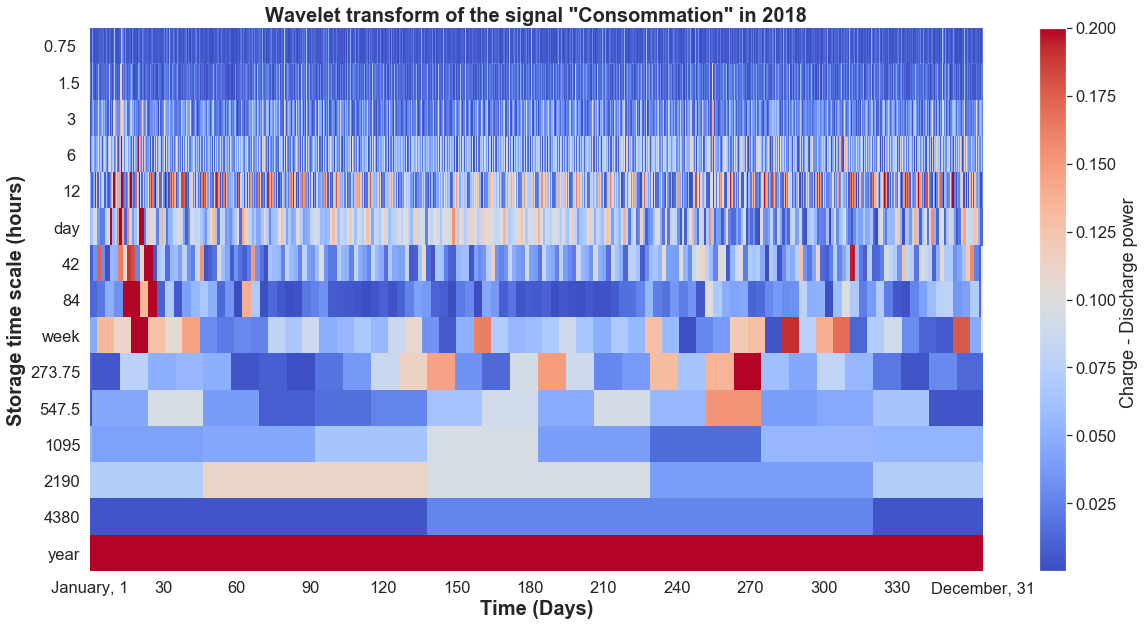

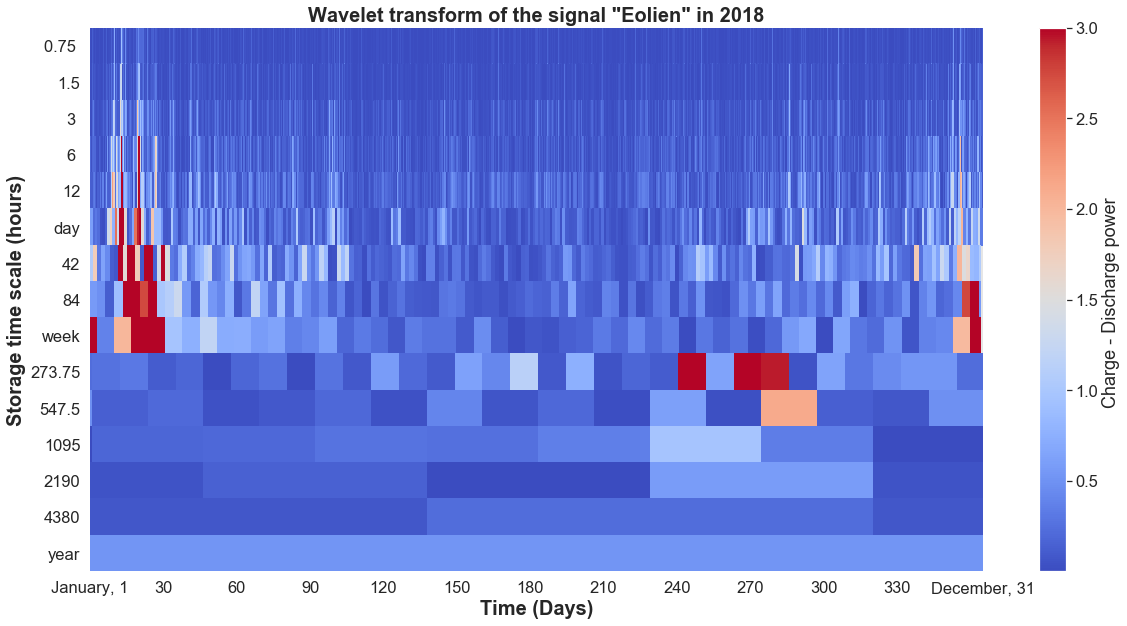

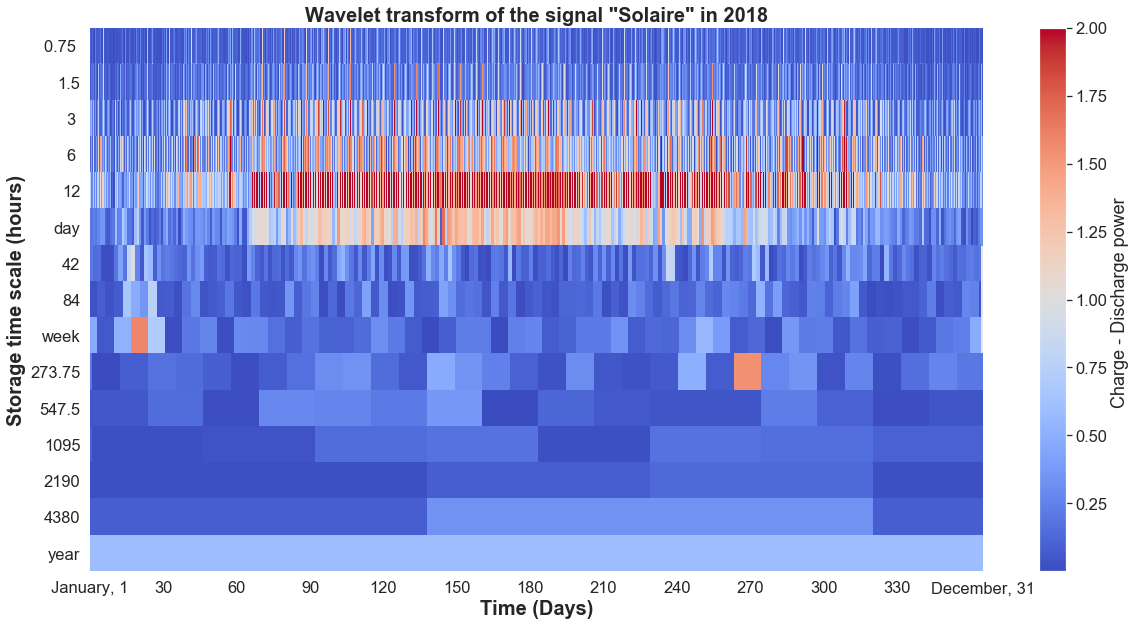

In [14]:
year = '2018'
df_conso_sine = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years,saved_sheets_sine, do_trans = trans_sine)
df_eol_sine   = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Eolien', year, years, saved_sheets_sine,   do_trans = trans_sine)
df_pv_sine    = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Solaire', year, years, saved_sheets_sine,  do_trans = trans_sine)

plot_betas_heatmap(df_conso_sine, 'Consommation', year , ndpd,
                      cmin= None,
                      cmax= 0.2,
                    ccenter = None)
plot_betas_heatmap(df_eol_sine, 'Eolien', year ,ndpd,
                      cmin= None,
                      cmax = 3,
                      ccenter= None)
plot_betas_heatmap(df_pv_sine, 'Solaire', year ,ndpd,
                      cmin= None,
                      cmax=2,
                      ccenter= None)


In [15]:
year = '2018'
df_conso_square = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years,saved_sheets_square, do_trans = trans_square)
df_conso_sine = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years,saved_sheets_sine, do_trans = trans_sine)


plot_betas_heatmap(df_conso_square, 'Consumption, Square WL decomposition', year , ndpd,
                      cmin= None,
                      cmax= 0.2,
                    ccenter = None)

plot_betas_heatmap(df_conso_sine, 'Consumption Sine WL decomposition', year , ndpd,
                      cmin= None,
                      cmax= 0.2,
                    ccenter = None)

NameError: name 'saved_sheets_square' is not defined

## Signal reconstruction
--

In [ ]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#
reconstruct(time_scales, [24],
                matrix,saved_sheets_sine['Solaire'][year], "Signal PV 2013 filtré par des ondelettes de 24h", xmin=0, xmax=15,
                dpy=365, dpd=64,
                add_offset=True)

## Computin E, P, N
--

***Beware:*** Energy calculation is still carried as before. However, since the wavelet shap has changed, it's value is now different

- Hwever, Energy and Service should only be multiplied by 2/pi =~ 0.64

In [ ]:
scenario_name = 'PV, sine wavelet decomposition'
sine_conso = stacked_betas_sine['Consommation']
sine_prod =  stacked_betas_sine['Solaire']

sine_pmc = [np.array(sine_prod[i]) - np.array(sine_conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_sine = calc_epn(sine_pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results_sine['emax'], results_sine['pmax'], results_sine['n'], results_sine['uf'], results_sine['serv'],
         time_scales, satisfactions, scenario_name )

# Impact of translations on the results
--


We proceed here to EPN calculation without optimizing the translation of mother wavelets of days, weeks and year

In [ ]:
#
# Create translations full of zeros
zero_trans = []
Nyears = int(len(stacked_input_data['Consommation'])/(ndpd*dpy) )
for i in range(Nyears):
    zero_trans.append([0,0,0])

In [ ]:
path_matrix = "saved_matrix\\square_shape\\"
beta_path = "betas\\square_shape_no_trans\\"

# stacked_betas_square_no_trans, saved_sheets_square_no_trans = compute_betas(time_series, stacked_input_data,
#                  vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
#                  zero_trans,
#                  path_matrix,
#                  beta_path, wl_shape ='square', imp_matrix = True)

# pkl.dump([stacked_betas_square_no_trans, saved_sheets_square_no_trans], open('betas_saved_square_no_trans' + '.p', "wb"))

[stacked_betas_square_no_trans, saved_sheets_square_no_trans] = pkl.load(open('betas_saved_square_no_trans' + '.p', "rb"))

In [ ]:
scenario_name = 'Wind, square wavelet decomposition with translation'
conso = stacked_betas_square['Consommation']
prod =  stacked_betas_square['Eolien']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_wind = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results_square_wind['emax'], results_square_wind['pmax'], results_square_wind['n'], results_square_wind['uf'], results_square_wind['serv'],
         time_scales, satisfactions, scenario_name )

In [ ]:
scenario_name = 'Wind, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consommation']
prod =  stacked_betas_square_no_trans['Eolien']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_wind_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results_square_wind_no_trans['emax'], results_square_wind_no_trans['pmax'], results_square_wind_no_trans['n'], results_square_wind_no_trans['uf'], results_square_wind_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

In [ ]:
scenario_name = 'PV, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consommation']
prod =  stacked_betas_square_no_trans['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_PV_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results_square_PV_no_trans['emax'], results_square_PV_no_trans['pmax'], results_square_PV_no_trans['n'], results_square_PV_no_trans['uf'], results_square_PV_no_trans['serv'],
         time_scales, satisfactions, scenario_name )